In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:2px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:10pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:11pt;padding:4px;}
table.dataframe{font-size:10px;}
</style>
"""))

In [ ]:
# 값에 마이너스가 나오면 안된다
# 아직도 예측 데이터가 안나온다


Importing plotly failed. Interactive plots will not work.


국적 입력 (없으면 Enter): 중국
목적 입력 (없으면 Enter): 

▶️ 공용 처리 시작

📊 [XGBoost 평가 지표]
MSE : 5144.58
RMSE: 71.73
R²  : 0.8147


연월  실제값        예측값
0  2021-07   16  17.303411
1  2021-08   31  17.303411
2  2021-09    8  19.707922
3  2021-10    3  19.068449
4  2021-11    6  18.267553
5  2021-12    5  14.618917
6  2022-01    8   6.146969
7  2022-02    3   6.146969
8  2022-03    5  25.475943
9  2022-04    3  24.836470

16:30:17 - cmdstanpy - INFO - Chain [1] start processing
16:30:17 - cmdstanpy - INFO - Chain [1] done processing


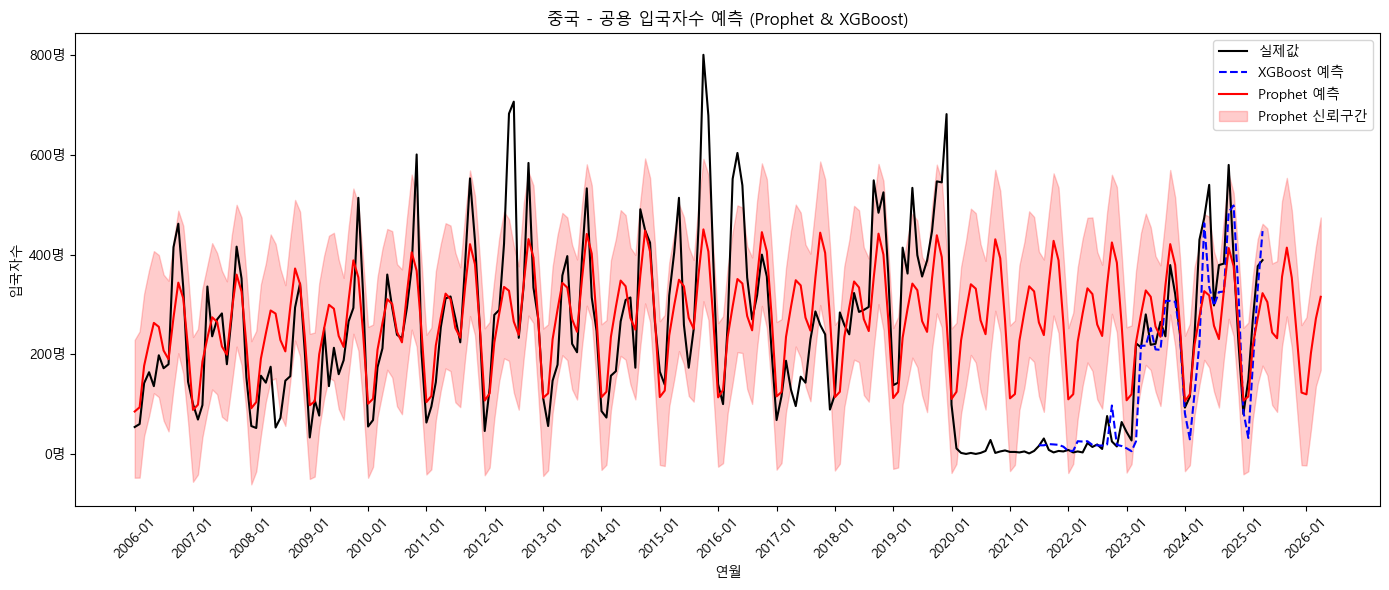


▶️ 관광 처리 시작

📊 [XGBoost 평가 지표]
MSE : 7682512907.50
RMSE: 87649.95
R²  : 0.6320


연월   실제값          예측값
0  2021-07  1031  6690.448730
1  2021-08  1011  6690.448730
2  2021-09  1264  3065.618164
3  2021-10  1366  3065.618164
4  2021-11  1700  1997.790161
5  2021-12  2151  2142.363281
6  2022-01  1641  3065.618164
7  2022-02  1194  3065.618164
8  2022-03  1480  4507.490234
9  2022-04  1857  4507.490234

16:30:18 - cmdstanpy - INFO - Chain [1] start processing
16:30:18 - cmdstanpy - INFO - Chain [1] done processing


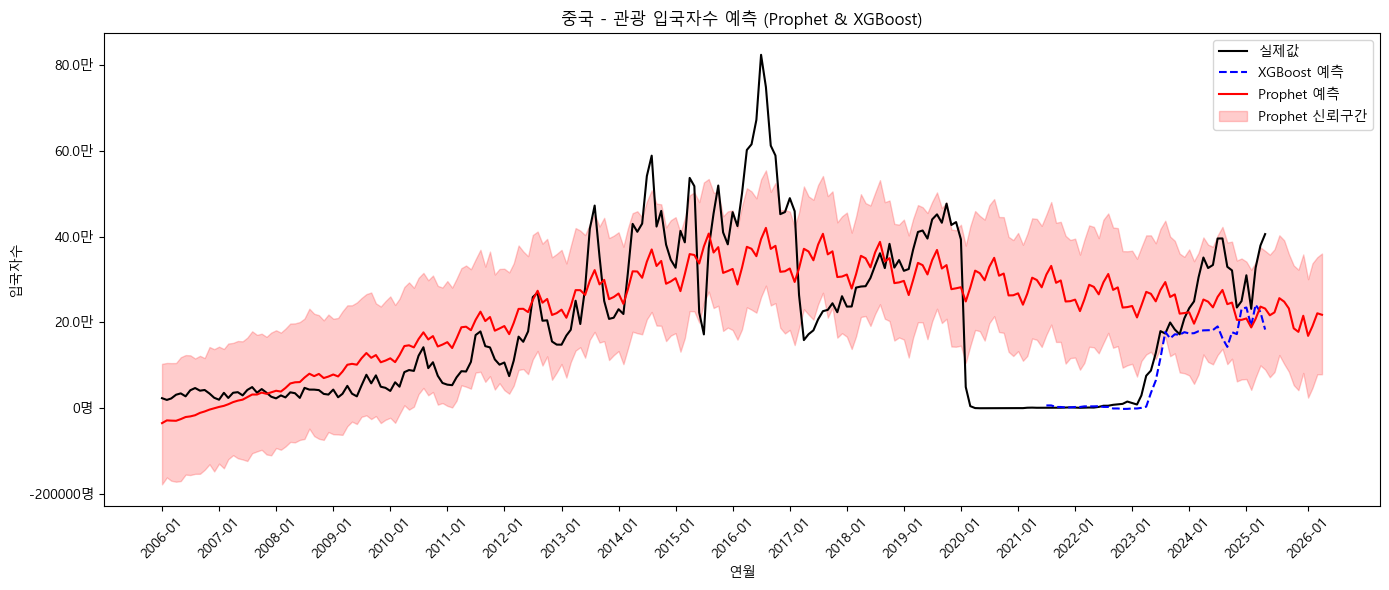


▶️ 상용 처리 시작

📊 [XGBoost 평가 지표]
MSE : 3096820.04
RMSE: 1759.78
R²  : -0.6238


연월  실제값         예측값
0  2021-07  277  511.247620
1  2021-08  270  511.247620
2  2021-09  354  571.250610
3  2021-10  322  571.250610
4  2021-11  382  571.250610
5  2021-12  283  571.250610
6  2022-01  170  377.705902
7  2022-02  381  377.705902
8  2022-03  303  693.416260
9  2022-04  318  571.250610

16:30:19 - cmdstanpy - INFO - Chain [1] start processing
16:30:19 - cmdstanpy - INFO - Chain [1] done processing


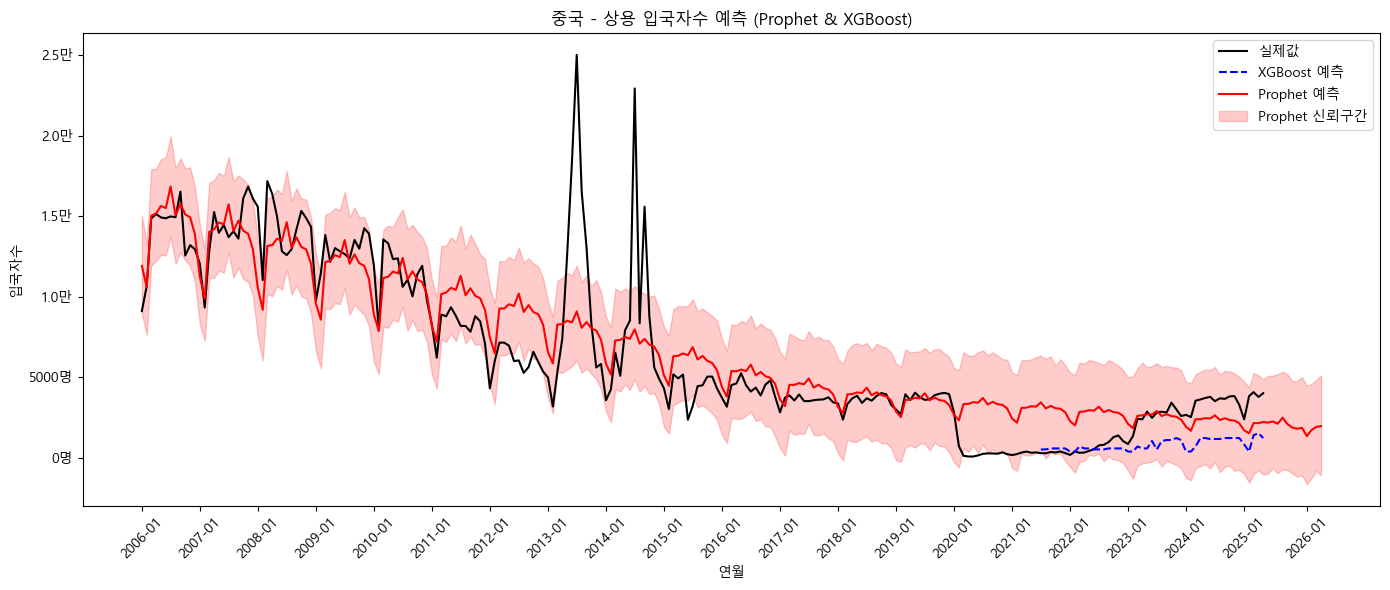


▶️ 유학연수 처리 시작

📊 [XGBoost 평가 지표]
MSE : 84933253.33
RMSE: 9215.92
R²  : 0.4009


연월   실제값          예측값
0  2021-07  1063  1691.799438
1  2021-08  9031  2542.035645
2  2021-09  7217  4951.700195
3  2021-10  1639  2551.909180
4  2021-11  1035  1804.772705
5  2021-12   848  1441.222900
6  2022-01   264  1962.665283
7  2022-02  7881  5319.472168
8  2022-03  5366  5407.401367
9  2022-04  1034  2649.961914

16:30:20 - cmdstanpy - INFO - Chain [1] start processing
16:30:20 - cmdstanpy - INFO - Chain [1] done processing


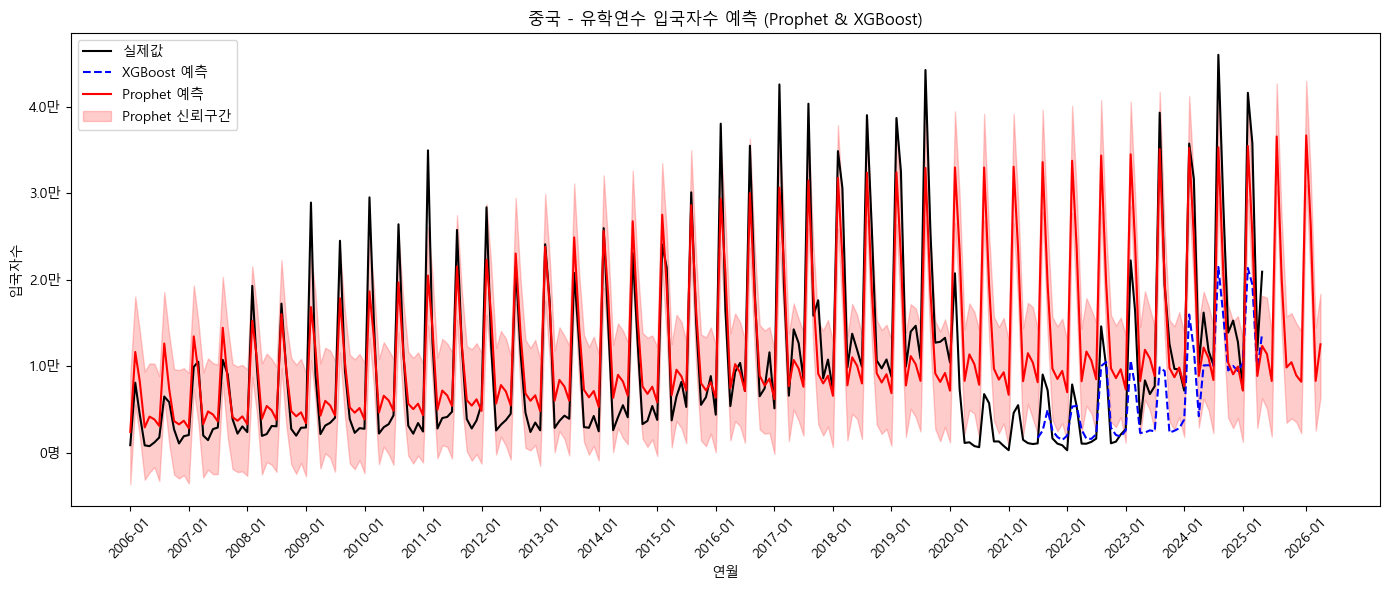

In [2]:
# ✅ [1] 라이브러리 임포트 및 설정
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ✅ [2] 데이터 로드
df = pd.read_csv('../../jin/data/processed/외국인입국자_전처리완료_딥러닝용.csv', encoding='utf-8')

# ✅ [3] 사용자 입력
def get_valid_input(column_name, allow_blank=False):
    unique_vals = df[column_name].unique()
    while True:
        user_input = input(f"{column_name} 입력 (없으면 Enter): ").strip().lower().replace(' ', '')
        if allow_blank and user_input == "":
            return None
        match = None
        for val in unique_vals:
            val_clean = val.strip().lower().replace(' ', '')
            if user_input == val_clean:
                match = val
                break
        if match:
            return match
        else:
            print(f"❌ 일치하는 {column_name} 없음. 다시 입력.")

country = get_valid_input('국적')
purpose_input = get_valid_input('목적', allow_blank=True)

df = df[df['국적'] == country]
purpose_list = [purpose_input] if purpose_input else df['목적'].unique()

# ✅ [4] Label Encoding + 파생변수
le_season = LabelEncoder()
le_corona = LabelEncoder()
df['계절'] = le_season.fit_transform(df['계절'])
df['코로나기간'] = le_corona.fit_transform(df['코로나기간'])
df['연월'] = df['연도'].astype(str) + '-' + df['월'].astype(str).str.zfill(2)
df['성수기'] = df['월'].apply(lambda x: 1 if x in [7, 8, 12] else 0) * 1.5
df['명절'] = df['월'].apply(lambda x: 1 if x in [1, 2, 9, 10] else 0) * 2.0

def to_unit(x, pos):
    if x >= 10000:
        return f'{x/10000:.1f}만'
    else:
        return f'{int(x)}명'

# ✅ [5] 목적별 루프
for purpose in purpose_list:
    print(f"\n▶️ {purpose} 처리 시작")
    temp_df = df[df['목적'] == purpose]
    if temp_df.empty:
        print(f"⚠️ 데이터 없음: {purpose}")
        continue

    # 파생 변수
    temp_df = temp_df.copy()
    temp_df['lag_1'] = temp_df['입국자수'].shift(1)
    temp_df['lag_3'] = temp_df['입국자수'].shift(3)
    temp_df['lag_12'] = temp_df['입국자수'].shift(12)
    temp_df['입국자수_cumsum'] = temp_df['입국자수'].cumsum()
    temp_df = temp_df.dropna()

    features = [
        '연도', '월', '분기', '계절', '코로나기간', '성수기', '명절',
        'lag_1', 'lag_3', 'lag_12', '입국자수_cumsum'
    ]
    X = temp_df[features]
    y = temp_df['입국자수']
    ym = temp_df['연월'].reset_index(drop=True)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test, ym_train, ym_test = train_test_split(
        X_scaled, y, ym, test_size=0.2, random_state=42, shuffle=False
    )

    params = {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3]}
    grid = GridSearchCV(XGBRegressor(), params, cv=2)
    grid.fit(X_train, y_train)
    xgb_model = grid.best_estimator_

    y_pred = xgb_model.predict(X_test)

    # ✅ 오차 지표 계산
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"\n📊 [XGBoost 평가 지표]")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²  : {r2:.4f}")

    # ✅ 예측값 표 출력
    results = pd.DataFrame({
        '연월': ym_test.values,
        '실제값': y_test.values,
        '예측값': y_pred
    })
    display(results.head(10))

    results['date'] = pd.to_datetime(results['연월'])
    temp_df['date'] = pd.to_datetime(temp_df['연월'])

    # ✅ Prophet 예측
    prophet_df = temp_df[['연월', '입국자수', '월', '코로나기간', '성수기', '명절']].copy()
    prophet_df.rename(columns={'연월': 'ds', '입국자수': 'y'}, inplace=True)
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

    m = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
    m.add_regressor('코로나기간')
    m.add_regressor('성수기')
    m.add_regressor('명절')
    m.fit(prophet_df)

    future = m.make_future_dataframe(periods=12, freq='M')
    future['월'] = future['ds'].dt.month
    future['코로나기간'] = 0
    future['성수기'] = future['월'].apply(lambda x: 1 if x in [7, 8, 12] else 0) * 1.5
    future['명절'] = future['월'].apply(lambda x: 1 if x in [1, 2, 9, 10] else 0) * 2.0

    forecast = m.predict(future)
    forecast['date'] = forecast['ds']

    # ✅ 시각화: 실제값, XGBoost, Prophet + 신뢰구간
    all_dates = pd.concat([temp_df['date'], forecast['date']]).drop_duplicates().sort_values()
    year_ticks = all_dates[all_dates.dt.month == 1]

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(temp_df['date'], temp_df['입국자수'], label='실제값', color='black')
    ax.plot(results['date'], results['예측값'], linestyle='--', label='XGBoost 예측', color='blue')
    ax.plot(forecast['date'], forecast['yhat'], linestyle='-', label='Prophet 예측', color='red')
    ax.fill_between(forecast['date'], forecast['yhat_lower'], forecast['yhat_upper'], 
                    color='red', alpha=0.2, label='Prophet 신뢰구간')

    ax.set_xticks(year_ticks)
    ax.set_xticklabels([d.strftime('%Y-%m') for d in year_ticks], rotation=45)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(to_unit))

    ax.set_title(f"{country} - {purpose} 입국자수 예측 (Prophet & XGBoost)")
    ax.set_xlabel('연월')
    ax.set_ylabel('입국자수')
    ax.legend()
    plt.tight_layout()
    plt.show()


Importing plotly failed. Interactive plots will not work.


국적 입력 (없으면 Enter): 중국
목적 입력 (없으면 Enter): 

▶️ 공용 처리 시작

📊 [XGBoost 평가 지표]
MSE (Mean Squared Error)  : 5144.58 → 낮을수록 좋음
RMSE (Root MSE)           : 71.73 → 낮을수록 좋음
R² (결정계수, 설명력)    : 0.8147 → 1에 가까울수록 좋음
📈 R² 해석 : 👍 양호


연월  실제값        예측값
0  2021-07   16  17.303411
1  2021-08   31  17.303411
2  2021-09    8  19.707922
3  2021-10    3  19.068449
4  2021-11    6  18.267553
5  2021-12    5  14.618917
6  2022-01    8   6.146969
7  2022-02    3   6.146969
8  2022-03    5  25.475943
9  2022-04    3  24.836470

16:37:57 - cmdstanpy - INFO - Chain [1] start processing
16:37:57 - cmdstanpy - INFO - Chain [1] done processing


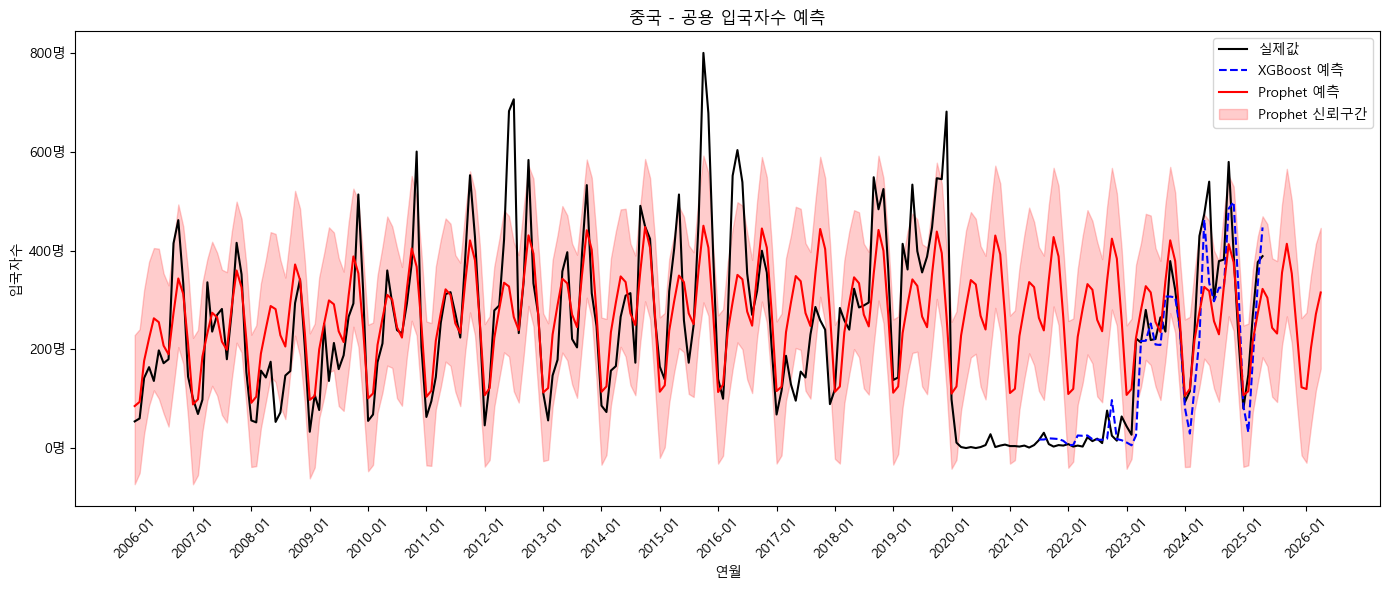


▶️ 관광 처리 시작

📊 [XGBoost 평가 지표]
MSE (Mean Squared Error)  : 7682512907.50 → 낮을수록 좋음
RMSE (Root MSE)           : 87649.95 → 낮을수록 좋음
R² (결정계수, 설명력)    : 0.6320 → 1에 가까울수록 좋음
📈 R² 해석 : ⚠️ 보통


연월   실제값          예측값
0  2021-07  1031  6690.448730
1  2021-08  1011  6690.448730
2  2021-09  1264  3065.618164
3  2021-10  1366  3065.618164
4  2021-11  1700  1997.790161
5  2021-12  2151  2142.363281
6  2022-01  1641  3065.618164
7  2022-02  1194  3065.618164
8  2022-03  1480  4507.490234
9  2022-04  1857  4507.490234

16:37:57 - cmdstanpy - INFO - Chain [1] start processing
16:37:58 - cmdstanpy - INFO - Chain [1] done processing


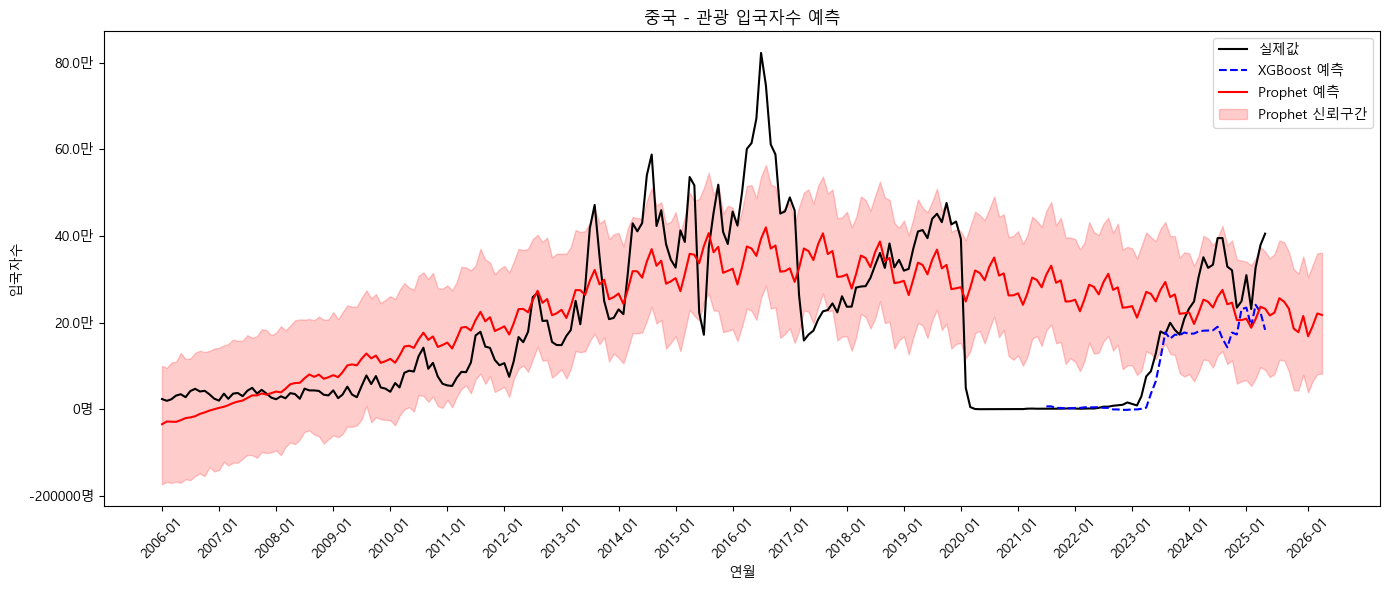


▶️ 상용 처리 시작

📊 [XGBoost 평가 지표]
MSE (Mean Squared Error)  : 3096820.04 → 낮을수록 좋음
RMSE (Root MSE)           : 1759.78 → 낮을수록 좋음
R² (결정계수, 설명력)    : -0.6238 → 1에 가까울수록 좋음
📈 R² 해석 : ❗ 낮음 (개선 필요)


연월  실제값         예측값
0  2021-07  277  511.247620
1  2021-08  270  511.247620
2  2021-09  354  571.250610
3  2021-10  322  571.250610
4  2021-11  382  571.250610
5  2021-12  283  571.250610
6  2022-01  170  377.705902
7  2022-02  381  377.705902
8  2022-03  303  693.416260
9  2022-04  318  571.250610

16:37:58 - cmdstanpy - INFO - Chain [1] start processing
16:37:58 - cmdstanpy - INFO - Chain [1] done processing


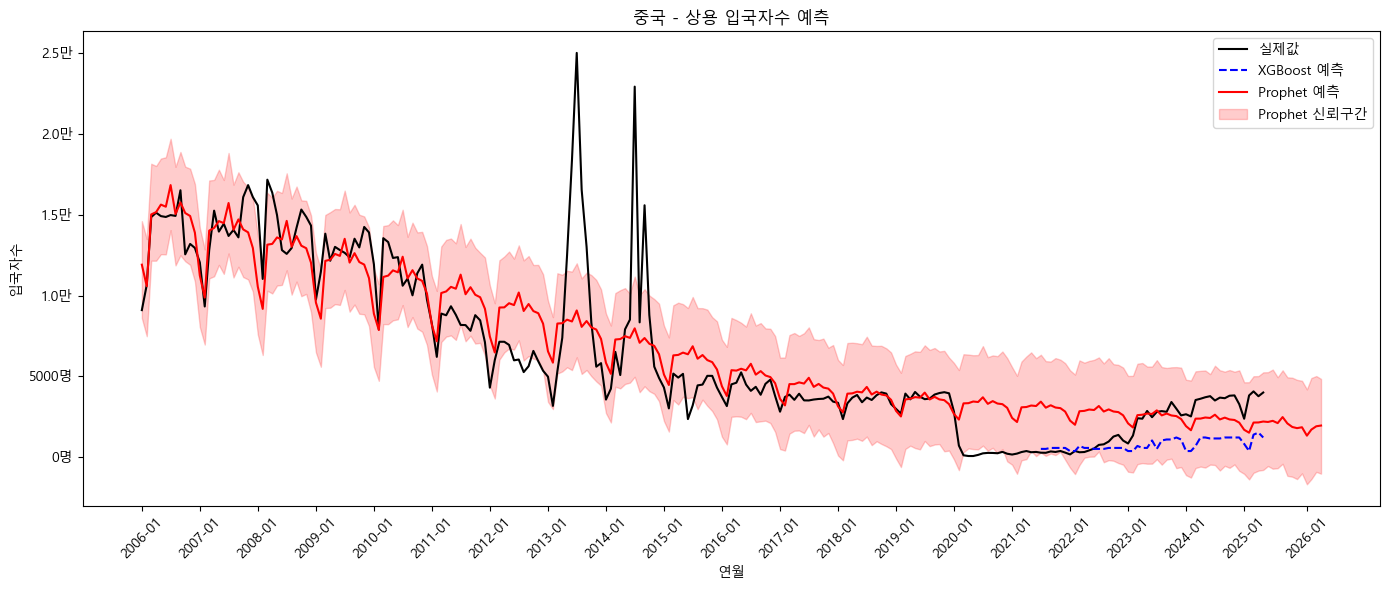


▶️ 유학연수 처리 시작

📊 [XGBoost 평가 지표]
MSE (Mean Squared Error)  : 84933253.33 → 낮을수록 좋음
RMSE (Root MSE)           : 9215.92 → 낮을수록 좋음
R² (결정계수, 설명력)    : 0.4009 → 1에 가까울수록 좋음
📈 R² 해석 : ❗ 낮음 (개선 필요)


연월   실제값          예측값
0  2021-07  1063  1691.799438
1  2021-08  9031  2542.035645
2  2021-09  7217  4951.700195
3  2021-10  1639  2551.909180
4  2021-11  1035  1804.772705
5  2021-12   848  1441.222900
6  2022-01   264  1962.665283
7  2022-02  7881  5319.472168
8  2022-03  5366  5407.401367
9  2022-04  1034  2649.961914

16:37:59 - cmdstanpy - INFO - Chain [1] start processing
16:37:59 - cmdstanpy - INFO - Chain [1] done processing


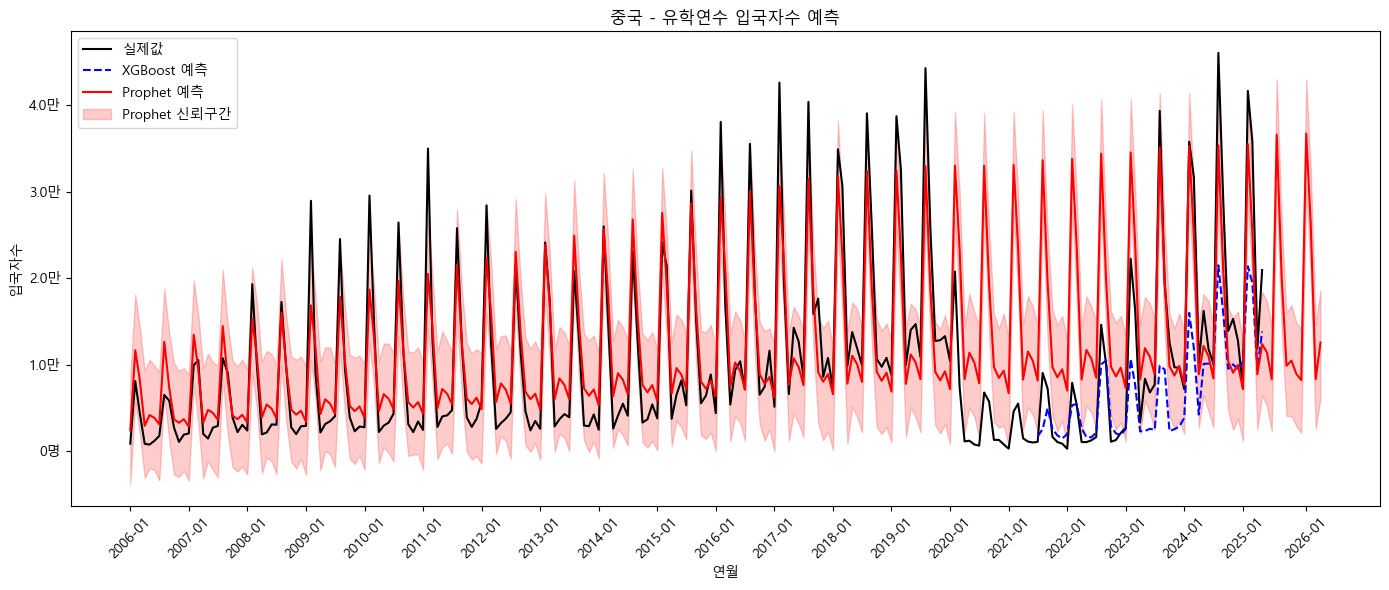


📅 예측 기간 조회
목적 입력 (없으면 Enter): 관광
연도 (예: 2025): 2026
월 (1~12): 4

📌 중국 / 관광 / 2026-04 예상 입국자수 : 217,758명


In [1]:
# ✅ [1] 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display
from datetime import datetime

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ✅ [2] 데이터 로드
df = pd.read_csv('../../jin/data/processed/외국인입국자_전처리완료_딥러닝용.csv', encoding='utf-8')

# ✅ [3] 사용자 입력
def get_valid_input(column_name, allow_blank=False):
    unique_vals = df[column_name].unique()
    while True:
        user_input = input(f"{column_name} 입력 (없으면 Enter): ").strip().lower().replace(' ', '')
        if allow_blank and user_input == "":
            return None
        match = None
        for val in unique_vals:
            val_clean = val.strip().lower().replace(' ', '')
            if user_input == val_clean:
                match = val
                break
        if match:
            return match
        else:
            print(f"❌ 일치하는 {column_name} 없음. 다시 입력.")

country = get_valid_input('국적')
purpose_input = get_valid_input('목적', allow_blank=True)

df = df[df['국적'] == country]
purpose_list = [purpose_input] if purpose_input else df['목적'].unique()

# ✅ [4] Label Encoding + 파생변수
le_season = LabelEncoder()
le_corona = LabelEncoder()
df['계절'] = le_season.fit_transform(df['계절'])
df['코로나기간'] = le_corona.fit_transform(df['코로나기간'])
df['연월'] = df['연도'].astype(str) + '-' + df['월'].astype(str).str.zfill(2)
df['성수기'] = df['월'].apply(lambda x: 1 if x in [7, 8, 12] else 0) * 1.5
df['명절'] = df['월'].apply(lambda x: 1 if x in [1, 2, 9, 10] else 0) * 2.0

def to_unit(x, pos):
    if x >= 10000:
        return f'{x/10000:.1f}만'
    else:
        return f'{int(x)}명'

# ✅ Prophet 모델 저장용
prophet_models = {}

# ✅ [5] 목적별 루프
for purpose in purpose_list:
    print(f"\n▶️ {purpose} 처리 시작")
    temp_df = df[df['목적'] == purpose]
    if temp_df.empty:
        print(f"⚠️ 데이터 없음: {purpose}")
        continue

    temp_df = temp_df.copy()
    temp_df['lag_1'] = temp_df['입국자수'].shift(1)
    temp_df['lag_3'] = temp_df['입국자수'].shift(3)
    temp_df['lag_12'] = temp_df['입국자수'].shift(12)
    temp_df['입국자수_cumsum'] = temp_df['입국자수'].cumsum()
    temp_df = temp_df.dropna()

    features = [
        '연도', '월', '분기', '계절', '코로나기간', '성수기', '명절',
        'lag_1', 'lag_3', 'lag_12', '입국자수_cumsum'
    ]
    X = temp_df[features]
    y = temp_df['입국자수']
    ym = temp_df['연월'].reset_index(drop=True)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test, ym_train, ym_test = train_test_split(
        X_scaled, y, ym, test_size=0.2, random_state=42, shuffle=False
    )

    params = {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3]}
    grid = GridSearchCV(XGBRegressor(), params, cv=2)
    grid.fit(X_train, y_train)
    xgb_model = grid.best_estimator_

    y_pred = xgb_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("\n📊 [XGBoost 평가 지표]")
    print(f"MSE (Mean Squared Error)  : {mse:.2f} → 낮을수록 좋음")
    print(f"RMSE (Root MSE)           : {rmse:.2f} → 낮을수록 좋음")
    print(f"R² (결정계수, 설명력)    : {r2:.4f} → 1에 가까울수록 좋음")

    if r2 >= 0.9:
        status = "✅ 매우 우수"
    elif r2 >= 0.7:
        status = "👍 양호"
    elif r2 >= 0.5:
        status = "⚠️ 보통"
    else:
        status = "❗ 낮음 (개선 필요)"
    print(f"📈 R² 해석 : {status}")

    results = pd.DataFrame({
        '연월': ym_test.values,
        '실제값': y_test.values,
        '예측값': y_pred
    })
    display(results.head(10))

    results['date'] = pd.to_datetime(results['연월'])
    temp_df['date'] = pd.to_datetime(temp_df['연월'])

    # ✅ Prophet 예측
    prophet_df = temp_df[['연월', '입국자수', '월', '코로나기간', '성수기', '명절']].copy()
    prophet_df.rename(columns={'연월': 'ds', '입국자수': 'y'}, inplace=True)
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

    m = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
    m.add_regressor('코로나기간')
    m.add_regressor('성수기')
    m.add_regressor('명절')
    m.fit(prophet_df)

    future = m.make_future_dataframe(periods=12, freq='M')
    future['월'] = future['ds'].dt.month
    future['코로나기간'] = 0
    future['성수기'] = future['월'].apply(lambda x: 1 if x in [7, 8, 12] else 0) * 1.5
    future['명절'] = future['월'].apply(lambda x: 1 if x in [1, 2, 9, 10] else 0) * 2.0

    forecast = m.predict(future)
    forecast['date'] = forecast['ds']

    prophet_models[purpose] = forecast

    # ✅ 그래프
    all_dates = pd.concat([temp_df['date'], forecast['date']]).drop_duplicates().sort_values()
    year_ticks = all_dates[all_dates.dt.month == 1]

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(temp_df['date'], temp_df['입국자수'], label='실제값', color='black')
    ax.plot(results['date'], results['예측값'], linestyle='--', label='XGBoost 예측', color='blue')
    ax.plot(forecast['date'], forecast['yhat'], linestyle='-', label='Prophet 예측', color='red')
    ax.fill_between(forecast['date'], forecast['yhat_lower'], forecast['yhat_upper'],
                    color='red', alpha=0.2, label='Prophet 신뢰구간')

    ax.set_xticks(year_ticks)
    ax.set_xticklabels([d.strftime('%Y-%m') for d in year_ticks], rotation=45)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(to_unit))

    ax.set_title(f"{country} - {purpose} 입국자수 예측")
    ax.set_xlabel('연월')
    ax.set_ylabel('입국자수')
    ax.legend()
    plt.tight_layout()
    plt.show()

# ✅ [6] 사용자 기간 예측 요청
print("\n📅 예측 기간 조회")
while True:
    query_purpose = get_valid_input('목적', allow_blank=False)
    if query_purpose not in prophet_models:
        print("⚠️ 해당 목적은 처리되지 않았음. 다시 입력.")
        continue
    forecast = prophet_models[query_purpose]

    # 기간 입력 받기
    query_year = int(input("연도 (예: 2025): "))
    query_month = int(input("월 (1~12): "))
    query_date = pd.to_datetime(f"{query_year}-{query_month:02d}-01")

    now = pd.to_datetime(datetime.now())
    max_date = now + pd.DateOffset(months=12)
    if query_date < now or query_date > max_date:
        print(f"⚠️ 입력 기간은 {now.strftime('%Y-%m')} ~ {max_date.strftime('%Y-%m')} 까지만 가능.")
        continue

    row = forecast[forecast['ds'].dt.to_period('M') == query_date.to_period('M')]
    if row.empty:
        print("❗ 해당 기간은 예측 데이터에 없음.")
    else:
        value = row['yhat'].values[0]
        print(f"\n📌 {country} / {query_purpose} / {query_year}-{query_month:02d} 예상 입국자수 : {int(value):,}명")
    break


국적 입력 (없으면 Enter): 
🌍 국적 미입력 → 전체 국가 사용
목적 입력 (없으면 Enter): 

▶️ 공용 처리 시작

📊 [XGBoost 평가 지표]
MSE (평균제곱오차): 629.38 → 낮을수록 좋음
RMSE (평균제곱근오차): 25.09 → 낮을수록 좋음
R² (결정계수): 0.8356 → 1에 가까울수록 좋음
📈 R² 해석 : 👍 양호


연월  실제값        예측값
0  2021-07    3   4.032517
1  2021-08   16   4.549887
2  2021-09    4  11.597907
3  2021-10    6   4.032517
4  2021-11   12   8.298028
5  2021-12    2   7.865893
6  2022-01   13   4.253949
7  2022-02    6  11.229088
8  2022-03    4   4.870987
9  2022-04   24   6.069591

17:05:21 - cmdstanpy - INFO - Chain [1] start processing
17:05:25 - cmdstanpy - INFO - Chain [1] done processing



▶️ 관광 처리 시작

📊 [XGBoost 평가 지표]
MSE (평균제곱오차): 14686982.73 → 낮을수록 좋음
RMSE (평균제곱근오차): 3832.36 → 낮을수록 좋음
R² (결정계수): 0.9006 → 1에 가까울수록 좋음
📈 R² 해석 : ✅ 매우 우수


연월   실제값         예측값
0  2021-07   196  527.807373
1  2021-08   267  527.807373
2  2021-09   353  527.807373
3  2021-10   495  555.163025
4  2021-11   476  656.802612
5  2021-12   401  619.188293
6  2022-01   171  608.236572
7  2022-02   205  550.636353
8  2022-03   293  550.636353
9  2022-04  3012  550.636353

17:05:26 - cmdstanpy - INFO - Chain [1] start processing
17:05:33 - cmdstanpy - INFO - Chain [1] done processing



▶️ 상용 처리 시작

📊 [XGBoost 평가 지표]
MSE (평균제곱오차): 1387.93 → 낮을수록 좋음
RMSE (평균제곱근오차): 37.25 → 낮을수록 좋음
R² (결정계수): 0.8859 → 1에 가까울수록 좋음
📈 R² 해석 : 👍 양호


연월  실제값        예측값
0  2021-07   18  21.998186
1  2021-08   25  23.045324
2  2021-09   36  26.661331
3  2021-10   43  36.856846
4  2021-11   49  39.762703
5  2021-12   19  44.666824
6  2022-01   15  31.053978
7  2022-02   16  35.493534
8  2022-03   26  21.998186
9  2022-04   22  28.247208

17:05:34 - cmdstanpy - INFO - Chain [1] start processing
17:05:36 - cmdstanpy - INFO - Chain [1] done processing



▶️ 유학연수 처리 시작

📊 [XGBoost 평가 지표]
MSE (평균제곱오차): 2462.94 → 낮을수록 좋음
RMSE (평균제곱근오차): 49.63 → 낮을수록 좋음
R² (결정계수): 0.8594 → 1에 가까울수록 좋음
📈 R² 해석 : 👍 양호


연월  실제값        예측값
0  2021-07    8  18.528893
1  2021-08   54  16.902107
2  2021-09   15  20.617979
3  2021-10    4  19.544510
4  2021-11   15  18.528893
5  2021-12    8  19.544510
6  2022-01   25  28.136232
7  2022-02  120  50.428337
8  2022-03   15  47.570179
9  2022-04    6  26.493752

17:05:37 - cmdstanpy - INFO - Chain [1] start processing
17:05:40 - cmdstanpy - INFO - Chain [1] done processing


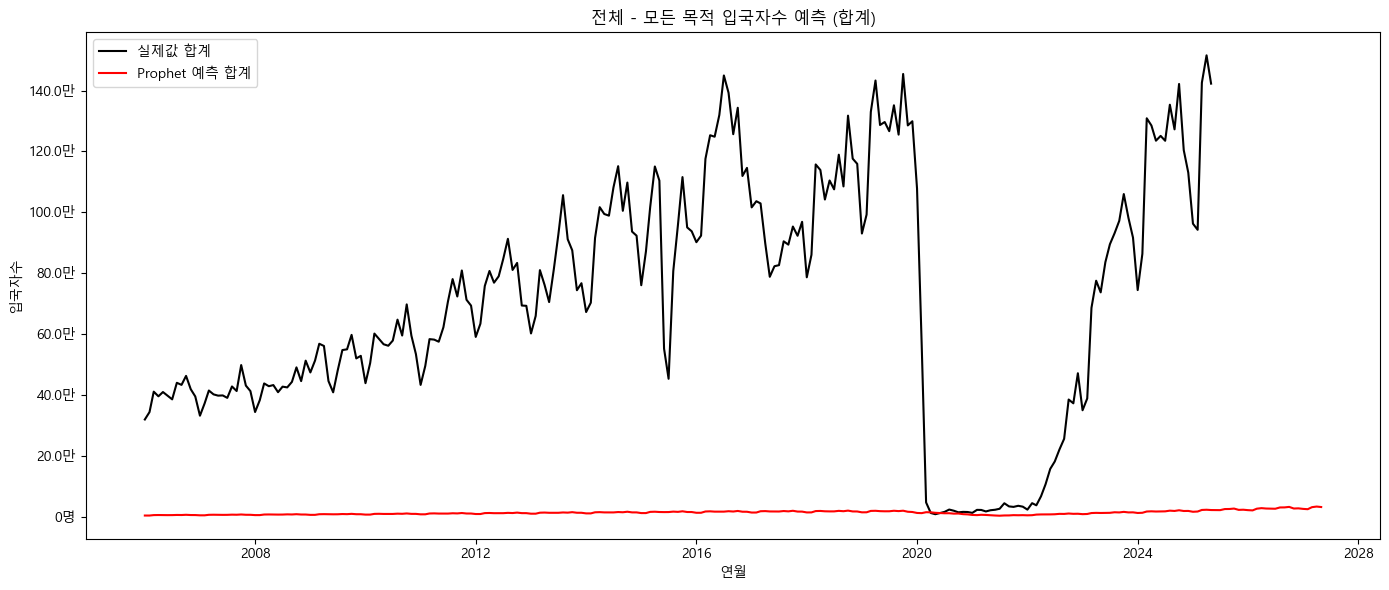


📅 원하는 예측 기간 조회

선택 가능 기간 표 (월 단위):
+---------+---------+---------+---------+---------+---------+
| 2025-07 | 2025-08 | 2025-09 | 2025-10 | 2025-11 | 2025-12 |
+---------+---------+---------+---------+---------+---------+
| 2026-01 | 2026-02 | 2026-03 | 2026-04 | 2026-05 | 2026-06 |
+---------+---------+---------+---------+---------+---------+
| 2026-07 | 2026-08 | 2026-09 | 2026-10 | 2026-11 | 2026-12 |
+---------+---------+---------+---------+---------+---------+
| 2027-01 | 2027-02 | 2027-03 | 2027-04 | 2027-05 | 2027-06 |
+---------+---------+---------+---------+---------+---------+
| 2027-07 |         |         |         |         |         |
+---------+---------+---------+---------+---------+---------+
예측 연월 입력 (예: 202507 또는 2025-07): 202601

📌 전체 / 모든 목적 / 2026-01 예상 입국자수 합계 : 21,402명


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display
from datetime import datetime
from tabulate import tabulate

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ✅ 데이터 로드
df = pd.read_csv('../../jin/data/processed/외국인입국자_전처리완료_딥러닝용.csv', encoding='utf-8')

# ✅ 입력 함수
def get_valid_input(column_name, allow_blank=False):
    unique_vals = df[column_name].unique()
    while True:
        user_input = input(f"{column_name} 입력 (없으면 Enter): ").strip().lower().replace(' ', '')
        if allow_blank and user_input == "":
            return None
        match = None
        for val in unique_vals:
            val_clean = val.strip().lower().replace(' ', '')
            if user_input == val_clean:
                match = val
                break
        if match:
            return match
        else:
            print(f"❌ 일치하는 {column_name} 없음. 다시 입력.")

# ✅ 국적 선택
country = get_valid_input('국적', allow_blank=True)
if country:
    df = df[df['국적'] == country]
    print(f"🌏 선택된 국적: {country}")
else:
    print("🌍 국적 미입력 → 전체 국가 사용")

# ✅ 목적 선택
purpose_input = get_valid_input('목적', allow_blank=True)
purpose_list = [purpose_input] if purpose_input else df['목적'].unique()

# ✅ 파생 변수 처리
le_season = LabelEncoder()
le_corona = LabelEncoder()
df['계절'] = le_season.fit_transform(df['계절'])
df['코로나기간'] = le_corona.fit_transform(df['코로나기간'])
df['연월'] = df['연도'].astype(str) + '-' + df['월'].astype(str).str.zfill(2)
df['성수기'] = df['월'].apply(lambda x: 1 if x in [7, 8, 12] else 0) * 1.5
df['명절'] = df['월'].apply(lambda x: 1 if x in [1, 2, 9, 10] else 0) * 2.0

def to_unit(x, pos):
    if x >= 10000:
        return f'{x/10000:.1f}만'
    else:
        return f'{int(x)}명'

# ✅ Prophet 결과 담기
prophet_forecasts = []
all_actuals = []

# ✅ 목적별 루프
for purpose in purpose_list:
    print(f"\n▶️ {purpose} 처리 시작")
    temp_df = df[df['목적'] == purpose]
    if temp_df.empty:
        print(f"⚠️ 데이터 없음: {purpose}")
        continue

    temp_df = temp_df.copy()
    temp_df['lag_1'] = temp_df['입국자수'].shift(1)
    temp_df['lag_3'] = temp_df['입국자수'].shift(3)
    temp_df['lag_12'] = temp_df['입국자수'].shift(12)
    temp_df['입국자수_cumsum'] = temp_df['입국자수'].cumsum()
    temp_df = temp_df.dropna()

    features = [
        '연도', '월', '분기', '계절', '코로나기간', '성수기', '명절',
        'lag_1', 'lag_3', 'lag_12', '입국자수_cumsum'
    ]
    X = temp_df[features]
    y = temp_df['입국자수']
    ym = temp_df['연월'].reset_index(drop=True)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test, ym_train, ym_test = train_test_split(
        X_scaled, y, ym, test_size=0.2, random_state=42, shuffle=False
    )

    params = {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3]}
    grid = GridSearchCV(XGBRegressor(), params, cv=2)
    grid.fit(X_train, y_train)
    xgb_model = grid.best_estimator_

    y_pred = xgb_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("\n📊 [XGBoost 평가 지표]")
    print(f"MSE (평균제곱오차): {mse:.2f} → 낮을수록 좋음")
    print(f"RMSE (평균제곱근오차): {rmse:.2f} → 낮을수록 좋음")
    print(f"R² (결정계수): {r2:.4f} → 1에 가까울수록 좋음")

    if r2 >= 0.9:
        status = "✅ 매우 우수"
    elif r2 >= 0.7:
        status = "👍 양호"
    elif r2 >= 0.5:
        status = "⚠️ 보통"
    else:
        status = "❗ 낮음 (개선 필요)"
    print(f"📈 R² 해석 : {status}")

    results = pd.DataFrame({
        '연월': ym_test.values,
        '실제값': y_test.values,
        '예측값': y_pred
    })
    display(results.head(10))

    # ✅ Prophet 학습
    prophet_df = temp_df[['연월', '입국자수', '월', '코로나기간', '성수기', '명절']].copy()
    prophet_df.rename(columns={'연월': 'ds', '입국자수': 'y'}, inplace=True)
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

    m = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
    m.add_regressor('코로나기간')
    m.add_regressor('성수기')
    m.add_regressor('명절')
    m.fit(prophet_df)

    future = m.make_future_dataframe(periods=24, freq='M')
    future['월'] = future['ds'].dt.month
    future['코로나기간'] = 0
    future['성수기'] = future['월'].apply(lambda x: 1 if x in [7, 8, 12] else 0) * 1.5
    future['명절'] = future['월'].apply(lambda x: 1 if x in [1, 2, 9, 10] else 0) * 2.0

    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat']]
    prophet_forecasts.append(forecast)

    # ✅ 실제값 누적
    temp_df['date'] = pd.to_datetime(temp_df['연월'])
    all_actuals.append(temp_df[['date', '입국자수']])

# ✅ 전체 Prophet 결과 합산
total_prophet = pd.concat(prophet_forecasts).groupby('ds').sum().reset_index()

# ✅ 전체 실제값 합산
total_actuals = pd.concat(all_actuals).groupby('date').sum().reset_index()

# ✅ 그래프: 전체 합계
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(total_actuals['date'], total_actuals['입국자수'], label='실제값 합계', color='black')
ax.plot(total_prophet['ds'], total_prophet['yhat'], label='Prophet 예측 합계', color='red')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(to_unit))
ax.set_title(f"{country if country else '전체'} - 모든 목적 입국자수 예측 (합계)")
ax.set_xlabel('연월')
ax.set_ylabel('입국자수')
ax.legend()
plt.tight_layout()
plt.show()

# ✅ 원하는 기간 조회
print("\n📅 원하는 예측 기간 조회")
now = pd.to_datetime(datetime.now()).replace(day=1)
max_date = now + pd.DateOffset(months=24)
possible_dates = pd.date_range(now, max_date, freq='MS').strftime('%Y-%m').tolist()

rows = [possible_dates[i:i+6] for i in range(0, len(possible_dates), 6)]
print("\n선택 가능 기간 표 (월 단위):")
print(tabulate(rows, tablefmt="grid"))

while True:
    query_input = input("예측 연월 입력 (예: 202507 또는 2025-07): ").strip().replace('-', '')
    if len(query_input) == 6:
        query_input = f"{query_input[:4]}-{query_input[4:]}"
    try:
        query_date = pd.to_datetime(query_input + "-01")
    except:
        print("❌ 형식 오류")
        continue

    if query_input not in possible_dates:
        print("⚠️ 가능한 기간이 아님. 표 참고.")
        continue

    row = total_prophet[total_prophet['ds'].dt.to_period('M') == query_date.to_period('M')]
    if row.empty:
        print("❗ 해당 기간 데이터 없음.")
    else:
        value = row['yhat'].values[0]
        print(f"\n📌 {country if country else '전체'} / 모든 목적 / {query_input} 예상 입국자수 합계 : {int(value):,}명")
    break


국적 입력 (없으면 Enter): 
목적 입력 (없으면 Enter): 
🌍 국적 미선택 → 모든 나라 사용


17:20:43 - cmdstanpy - INFO - Chain [1] start processing
17:20:44 - cmdstanpy - INFO - Chain [1] done processing


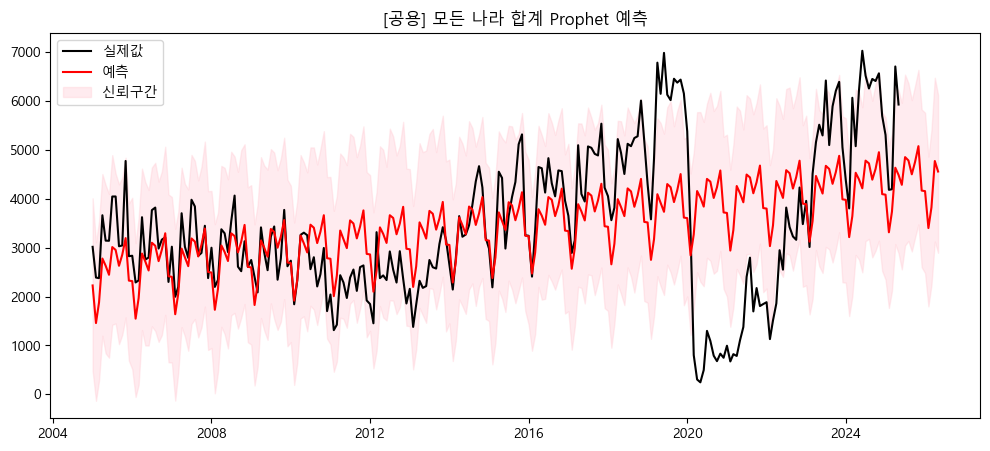

17:20:44 - cmdstanpy - INFO - Chain [1] start processing



✅ 공용 Prophet 결과 샘플
            ds         yhat   yhat_lower   yhat_upper
254 2026-02-28  3823.621719  2241.346803  5400.220750
255 2026-03-31  4772.279322  3125.926643  6474.358208
256 2026-04-30  4557.165657  2894.652250  6121.923794


17:20:44 - cmdstanpy - INFO - Chain [1] done processing


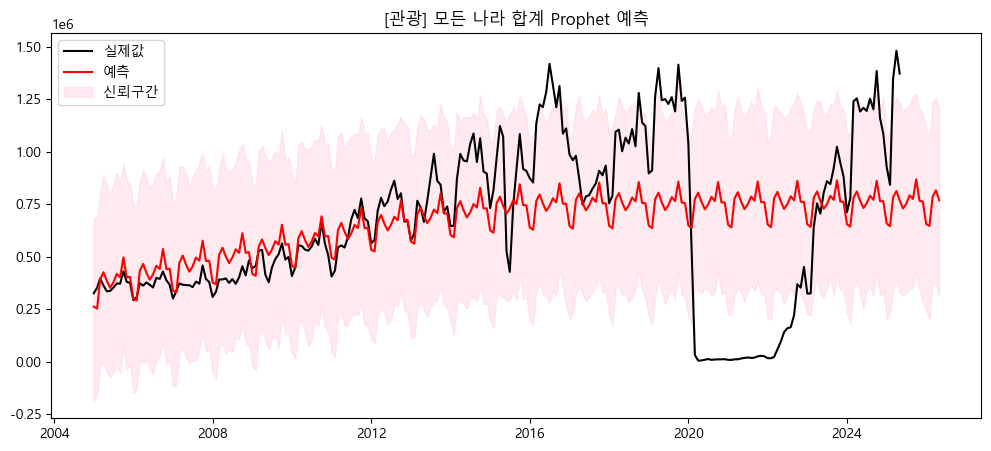

17:20:45 - cmdstanpy - INFO - Chain [1] start processing



✅ 관광 Prophet 결과 샘플
            ds           yhat     yhat_lower    yhat_upper
254 2026-02-28  785054.390933  381461.268750  1.240190e+06
255 2026-03-31  815843.657291  365533.638146  1.254916e+06
256 2026-04-30  768304.241551  310645.541554  1.204636e+06


17:20:45 - cmdstanpy - INFO - Chain [1] done processing


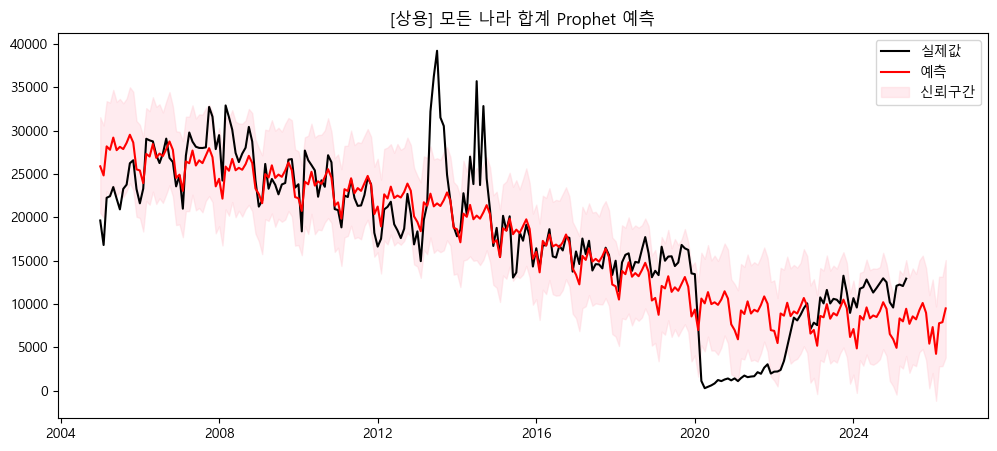

17:20:45 - cmdstanpy - INFO - Chain [1] start processing



✅ 상용 Prophet 결과 샘플
            ds         yhat   yhat_lower    yhat_upper
254 2026-02-28  7776.246062  2800.925221  13145.567026
255 2026-03-31  7898.457492  2832.857049  13139.467104
256 2026-04-30  9489.910818  3834.004449  15066.149031


17:20:45 - cmdstanpy - INFO - Chain [1] done processing


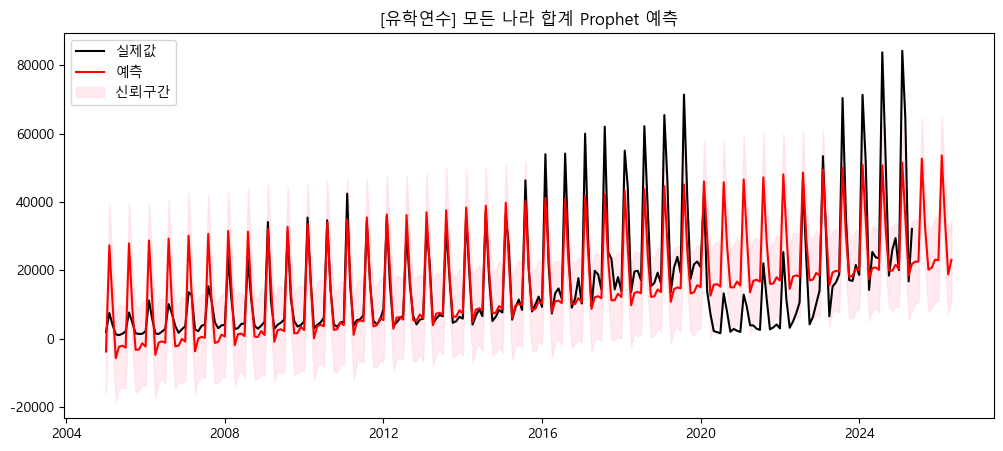


✅ 유학연수 Prophet 결과 샘플
            ds          yhat    yhat_lower    yhat_upper
254 2026-02-28  35553.115733  22785.640745  47610.503839
255 2026-03-31  18784.597050   7367.644655  30294.870795
256 2026-04-30  23033.501172  11780.049243  34827.863795


C:\Users\Admin\AppData\Local\Temp\ipykernel_9516\1353229142.py:75: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_actuals = pd.concat(actual_results.values()).groupby('ds').sum().reset_index()


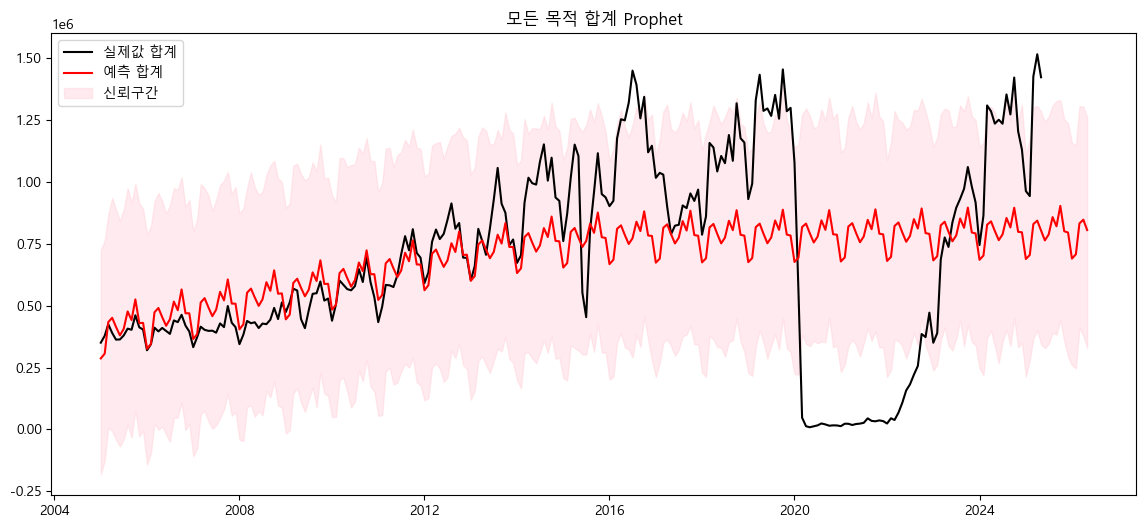


📅 원하는 예측 연월
+---------+---------+---------+---------+---------+---------+
| 2025-07 | 2025-08 | 2025-09 | 2025-10 | 2025-11 | 2025-12 |
+---------+---------+---------+---------+---------+---------+
| 2026-01 | 2026-02 | 2026-03 | 2026-04 | 2026-05 | 2026-06 |
+---------+---------+---------+---------+---------+---------+
| 2026-07 | 2026-08 | 2026-09 | 2026-10 | 2026-11 | 2026-12 |
+---------+---------+---------+---------+---------+---------+
| 2027-01 | 2027-02 | 2027-03 | 2027-04 | 2027-05 | 2027-06 |
+---------+---------+---------+---------+---------+---------+
| 2027-07 |         |         |         |         |         |
+---------+---------+---------+---------+---------+---------+
연월 입력 (202507 또는 2025-07): 202605
⚠️ 공용 에서 2026-05 데이터 없음 → 점 표시 안 함


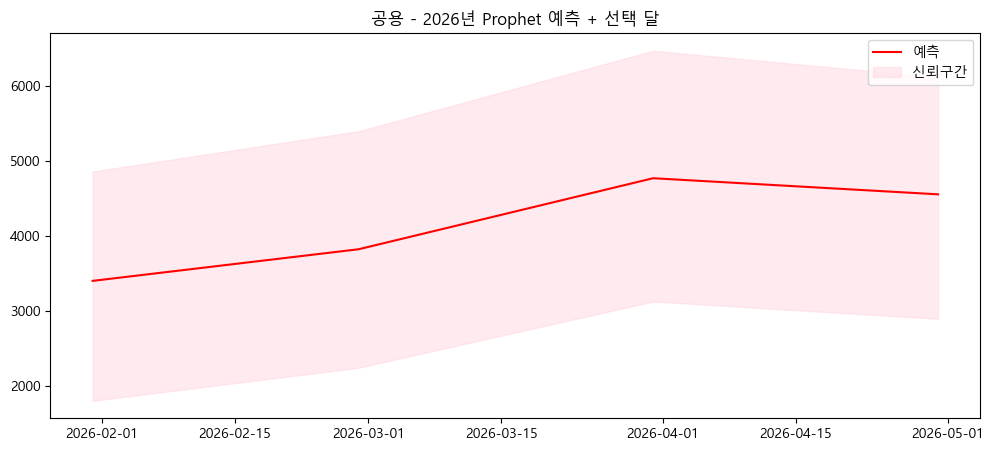

⚠️ 관광 에서 2026-05 데이터 없음 → 점 표시 안 함


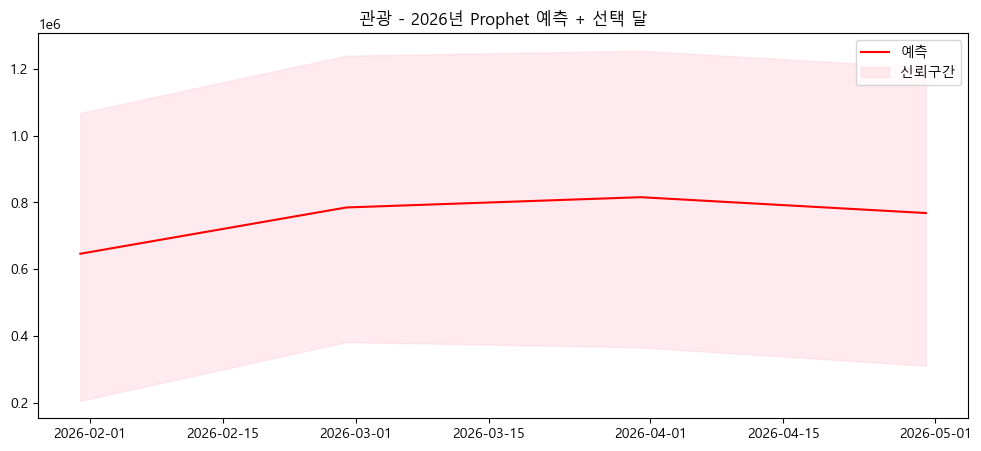

⚠️ 상용 에서 2026-05 데이터 없음 → 점 표시 안 함


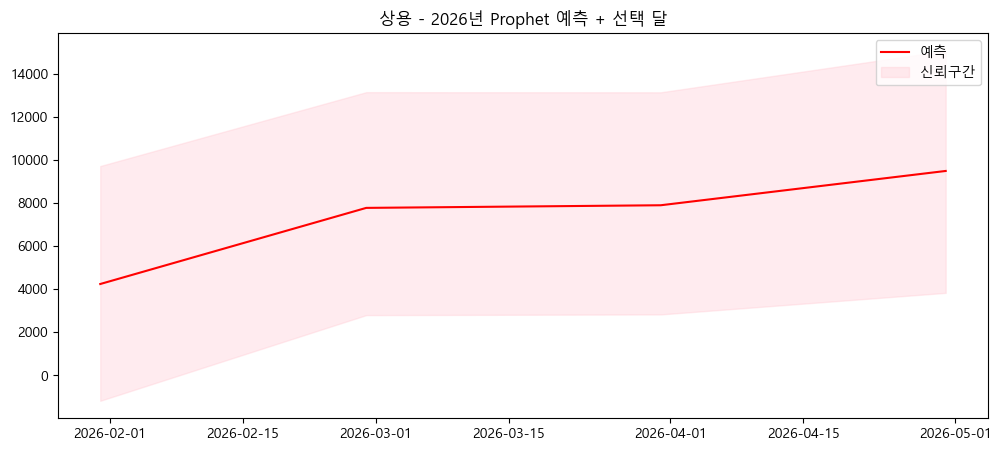

⚠️ 유학연수 에서 2026-05 데이터 없음 → 점 표시 안 함


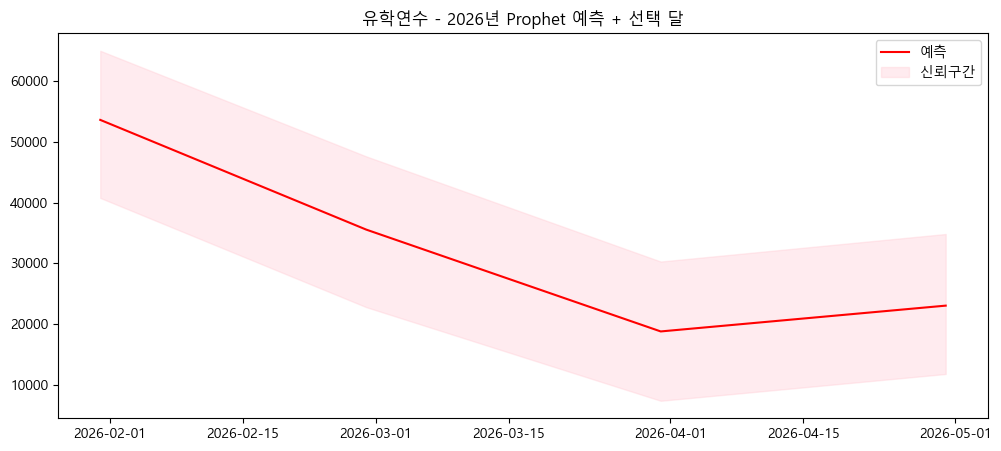

In [10]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ✅ 데이터 로드
df = pd.read_csv('../../jin/data/processed/외국인입국자_전처리완료_딥러닝용.csv')

# ✅ 입력
country = input("국적 입력 (없으면 Enter): ").strip()
purpose = input("목적 입력 (없으면 Enter): ").strip()

# ✅ 국적 필터
if country:
    df = df[df['국적'] == country]
else:
    print("🌍 국적 미선택 → 모든 나라 사용")

# ✅ 목적 리스트
purpose_list = [purpose] if purpose else df['목적'].unique()

# ✅ 파생
df['연월'] = df['연도'].astype(str) + '-' + df['월'].astype(str).str.zfill(2)

# ✅ 국적 미선택이면 같은 목적별로 모든 나라 데이터 합산
if not country:
    grouped = df.groupby(['연월', '목적'], as_index=False)['입국자수'].sum()
else:
    grouped = df.copy()

prophet_results = {}
actual_results = {}

# ✅ 목적별 루프
for pur in purpose_list:
    temp = grouped[grouped['목적'] == pur].copy()
    if temp.empty:
        print(f"❌ 데이터 없음: {pur}")
        continue

    temp['ds'] = pd.to_datetime(temp['연월'])
    temp['y'] = temp['입국자수']

    # Prophet
    m = Prophet(yearly_seasonality=True)
    m.fit(temp[['ds', 'y']])

    future = m.make_future_dataframe(periods=12, freq='M')
    forecast = m.predict(future)

    prophet_results[pur] = forecast
    actual_results[pur] = temp

    # ✅ 목적별 그래프
    plt.figure(figsize=(12,5))
    plt.plot(temp['ds'], temp['y'], label='실제값', color='black')
    plt.plot(forecast['ds'], forecast['yhat'], label='예측', color='red')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                     color='pink', alpha=0.3, label='신뢰구간')
    plt.title(f"[{pur}] 모든 나라 합계 Prophet 예측")
    plt.legend()
    plt.show()

    print(f"\n✅ {pur} Prophet 결과 샘플")
    print(forecast.tail(3)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# ✅ 목적 미선택이면 전체 목적 합산도
if not purpose:
    total_prophet = pd.concat(prophet_results.values()).groupby('ds').sum().reset_index()
    total_actuals = pd.concat(actual_results.values()).groupby('ds').sum().reset_index()

    plt.figure(figsize=(14,6))
    plt.plot(total_actuals['ds'], total_actuals['y'], label='실제값 합계', color='black')
    plt.plot(total_prophet['ds'], total_prophet['yhat'], label='예측 합계', color='red')
    plt.fill_between(total_prophet['ds'], total_prophet['yhat_lower'], total_prophet['yhat_upper'],
                     alpha=0.3, color='pink', label='신뢰구간')
    plt.title("모든 목적 합계 Prophet")
    plt.legend()
    plt.show()

# ✅ 연월 입력
print("\n📅 원하는 예측 연월")
now = pd.to_datetime(datetime.now()).replace(day=1)
possible_dates = pd.date_range(now, now + pd.DateOffset(months=24), freq='MS').strftime('%Y-%m').tolist()
rows = [possible_dates[i:i+6] for i in range(0, len(possible_dates), 6)]
print(tabulate(rows, tablefmt="grid"))

query = input("연월 입력 (202507 또는 2025-07): ").strip().replace('-', '')
if len(query) == 6:
    query = f"{query[:4]}-{query[4:]}"

query_date = pd.to_datetime(query + "-01")
query_year = query_date.year

# ✅ 목적별로 해당 연도 그래프 + 요청한 달 강조
if purpose:
    targets = [purpose]
else:
    targets = list(prophet_results.keys())

for pur in targets:
    fc = prophet_results[pur]
    one_year = fc[fc['ds'].dt.year == query_year]

    plt.figure(figsize=(12,5))
    plt.plot(one_year['ds'], one_year['yhat'], label='예측', color='red')
    plt.fill_between(one_year['ds'], one_year['yhat_lower'], one_year['yhat_upper'],
                     alpha=0.3, color='pink', label='신뢰구간')

    point = one_year.loc[one_year['ds'] == query_date, 'yhat']
    if not point.empty:
        plt.scatter(query_date, point.values[0],
                    color='blue', label=f'{query} 예측값')
    else:
        print(f"⚠️ {pur} 에서 {query} 데이터 없음 → 점 표시 안 함")

    plt.title(f"{pur} - {query_year}년 Prophet 예측 + 선택 달")
    plt.legend()
    plt.show()

    if not point.empty:
        print(f"📌 {pur} / {query} 예상 입국자수: {int(point.values[0]):,}명")


In [12]:
import pandas as pd
import numpy as np
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 데이터 로드
df = pd.read_csv('../../jin/data/processed/외국인입국자_전처리완료_딥러닝용.csv')

country = input("국적 입력 (없으면 Enter): ").strip()
purpose = input("목적 입력 (없으면 Enter): ").strip()

if country:
    df = df[df['국적'] == country]
else:
    print("🌍 국적 미선택 → 모든 나라 사용")

purpose_list = [purpose] if purpose else df['목적'].unique()

df['연월'] = df['연도'].astype(str) + '-' + df['월'].astype(str).str.zfill(2)

# 국적 미선택이면 같은 목적끼리 합계
if not country:
    grouped = df.groupby(['연월', '목적'], as_index=False)['입국자수'].sum()
else:
    grouped = df.copy()

prophet_results = {}
xgb_results = {}
actuals = {}

for pur in purpose_list:
    temp = grouped[grouped['목적'] == pur].copy()
    if temp.empty:
        print(f"❌ 데이터 없음: {pur}")
        continue

    temp['ds'] = pd.to_datetime(temp['연월'])
    temp['y'] = temp['입국자수']

    # ✅ Prophet
    m = Prophet(yearly_seasonality=True)
    m.fit(temp[['ds', 'y']])
    future = m.make_future_dataframe(periods=12, freq='M')
    forecast = m.predict(future)
    prophet_results[pur] = forecast

    # ✅ XGBoost
    temp['연도'] = temp['ds'].dt.year
    temp['월'] = temp['ds'].dt.month
    temp['lag_1'] = temp['y'].shift(1)
    temp = temp.dropna()

    X = temp[['연도', '월', 'lag_1']]
    y = temp['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb = XGBRegressor()
    xgb.fit(X_train_scaled, y_train)
    y_pred = xgb.predict(X_test_scaled)

    # test 연월과 예측값 연결
    xgb_df = pd.DataFrame({'ds': temp.iloc[y_test.index]['ds'], 'xgb_yhat': y_pred})
    xgb_results[pur] = xgb_df
    actuals[pur] = temp

    # ✅ 목적별 Prophet + XGBoost 그래프 출력
    plt.figure(figsize=(12,5))
    plt.plot(temp['ds'], temp['y'], label='실제값', color='black')
    plt.plot(forecast['ds'], forecast['yhat'], label='Prophet', color='red')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                     alpha=0.2, color='pink', label='Prophet 신뢰구간')
    plt.plot(xgb_df['ds'], xgb_df['xgb_yhat'], label='XGBoost', color='blue')
    plt.title(f"[{pur}] 모든 나라 Prophet + XGBoost")
    plt.legend()
    plt.show()

# ✅ 목적 미선택이면 Prophet 전체 합계 계산
if not purpose:
    total_prophet = pd.concat(prophet_results.values()).groupby('ds').sum().reset_index()
    total_actuals = pd.concat(actuals.values()).groupby('ds').sum().reset_index()

    plt.figure(figsize=(14,6))
    plt.plot(total_actuals['ds'], total_actuals['y'], label='실제값 합계', color='black')
    plt.plot(total_prophet['ds'], total_prophet['yhat'], label='Prophet 합계', color='red')
    plt.fill_between(total_prophet['ds'], total_prophet['yhat_lower'], total_prophet['yhat_upper'],
                     alpha=0.3, color='pink', label='Prophet 신뢰구간')
    plt.title("모든 목적 합계 Prophet")
    plt.legend()
    plt.show()

# ✅ 원하는 연월
print("\n📅 원하는 연월 선택")
now = pd.to_datetime(datetime.now()).replace(day=1)
possible = pd.date_range(now, now + pd.DateOffset(months=24), freq='MS').strftime('%Y-%m').tolist()
rows = [possible[i:i+6] for i in range(0, len(possible), 6)]
print(tabulate(rows, tablefmt="grid"))

query = input("연월 입력 (202507 또는 2025-07): ").strip().replace('-', '')
if len(query) == 6:
    query = f"{query[:4]}-{query[4:]}"
query_date = pd.to_datetime(query + "-01")
query_year = query_date.year

# ✅ 목적 선택시 → 선택 목적 + 전체 합계 Prophet
if purpose:
    # 개별 목적 Prophet + XGBoost
    fc = prophet_results[purpose]
    one_year = fc[fc['ds'].dt.year == query_year]

    plt.figure(figsize=(12,5))
    plt.plot(one_year['ds'], one_year['yhat'], label='Prophet', color='red')
    plt.fill_between(one_year['ds'], one_year['yhat_lower'], one_year['yhat_upper'],
                     alpha=0.3, color='pink')
    xgb = xgb_results[purpose]
    xgb_year = xgb[xgb['ds'].dt.year == query_year]
    plt.plot(xgb_year['ds'], xgb_year['xgb_yhat'], label='XGBoost', color='blue')

    point = one_year.loc[one_year['ds'] == query_date, 'yhat']
    if not point.empty:
        plt.scatter(query_date, point.values[0], color='black', label='선택달')
    plt.title(f"{purpose} Prophet+XGB ({query_year})")
    plt.legend()
    plt.show()

    print(f"{purpose} / {query}: {int(point.values[0]) if not point.empty else 'N/A'}명")

    # 전체 Prophet 합계
    total_prophet = pd.concat(prophet_results.values()).groupby('ds').sum().reset_index()
    one_year_sum = total_prophet[total_prophet['ds'].dt.year == query_year]
    plt.figure(figsize=(12,5))
    plt.plot(one_year_sum['ds'], one_year_sum['yhat'], label='전체 Prophet', color='red')
    plt.fill_between(one_year_sum['ds'], one_year_sum['yhat_lower'], one_year_sum['yhat_upper'],
                     alpha=0.2, color='pink')
    p2 = one_year_sum.loc[one_year_sum['ds'] == query_date, 'yhat']
    if not p2.empty:
        plt.scatter(query_date, p2.values[0], color='black', label='선택달')
    plt.title(f"모든 목적 Prophet 합계 ({query_year})")
    plt.legend()
    plt.show()
    print(f"모든 목적 합계 / {query}: {int(p2.values[0]) if not p2.empty else 'N/A'}명")

# ✅ 목적 미선택이면 → 전체 Prophet 합계만
if not purpose:
    one_year_sum = total_prophet[total_prophet['ds'].dt.year == query_year]
    plt.figure(figsize=(12,5))
    plt.plot(one_year_sum['ds'], one_year_sum['yhat'], label='전체 Prophet', color='red')
    plt.fill_between(one_year_sum['ds'], one_year_sum['yhat_lower'], one_year_sum['yhat_upper'],
                     alpha=0.2, color='pink')
    p2 = one_year_sum.loc[one_year_sum['ds'] == query_date, 'yhat']
    if not p2.empty:
        plt.scatter(query_date, p2.values[0], color='black', label='선택달')
    plt.title(f"모든 목적 Prophet 합계 ({query_year})")
    plt.legend()
    plt.show()
    print(f"모든 목적 합계 / {query}: {int(p2.values[0]) if not p2.empty else 'N/A'}명")


국적 입력 (없으면 Enter): 
목적 입력 (없으면 Enter): 
🌍 국적 미선택 → 모든 나라 사용


17:31:30 - cmdstanpy - INFO - Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1] done processing


IndexError: positional indexers are out-of-bounds

국적 입력 (없으면 Enter): 
목적 입력 (없으면 Enter): 
🌍 국적 미선택 → 모든 나라 사용


17:46:35 - cmdstanpy - INFO - Chain [1] start processing
17:46:35 - cmdstanpy - INFO - Chain [1] done processing


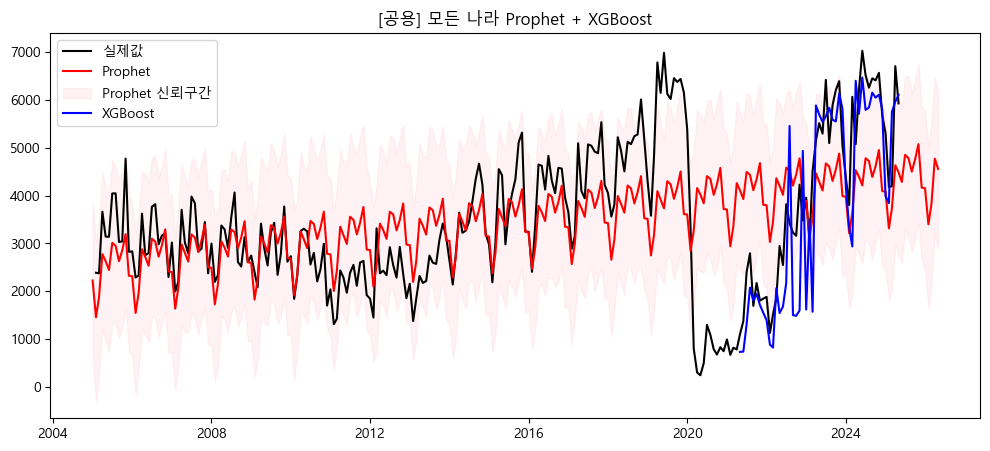

17:46:36 - cmdstanpy - INFO - Chain [1] start processing
17:46:36 - cmdstanpy - INFO - Chain [1] done processing


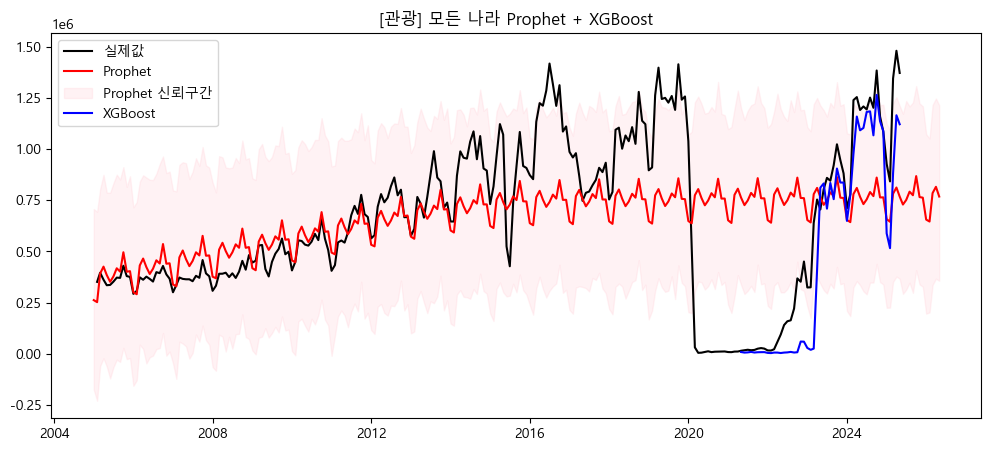

17:46:36 - cmdstanpy - INFO - Chain [1] start processing
17:46:36 - cmdstanpy - INFO - Chain [1] done processing


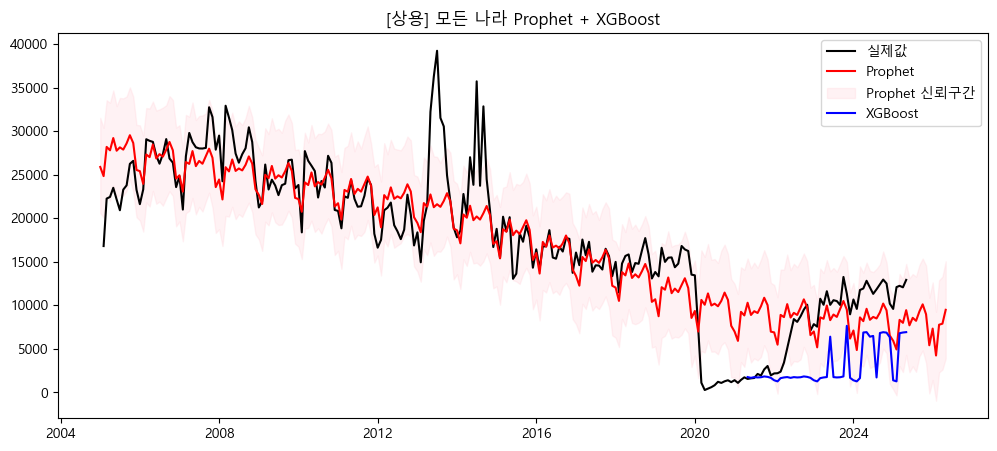

17:46:37 - cmdstanpy - INFO - Chain [1] start processing
17:46:37 - cmdstanpy - INFO - Chain [1] done processing


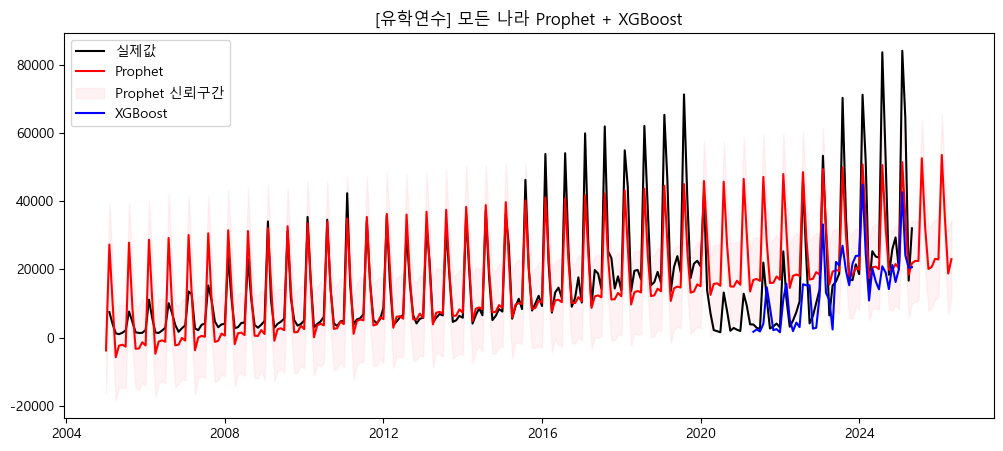

C:\Users\Admin\AppData\Local\Temp\ipykernel_9516\2375994513.py:92: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_actuals = pd.concat(actuals.values()).groupby('ds').sum().reset_index()


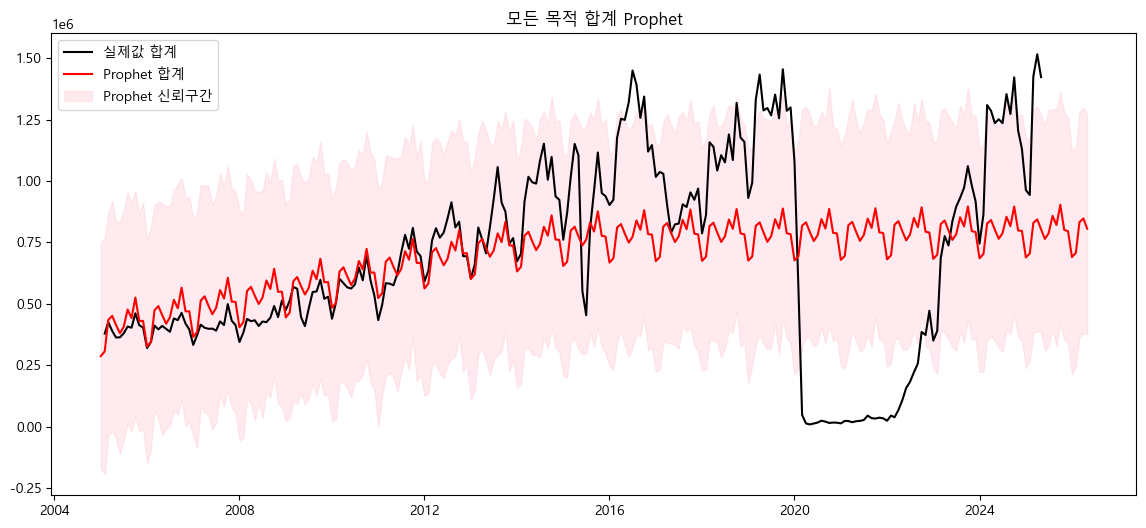


📅 원하는 연월 선택
+---------+---------+---------+---------+---------+---------+
| 2025-07 | 2025-08 | 2025-09 | 2025-10 | 2025-11 | 2025-12 |
+---------+---------+---------+---------+---------+---------+
| 2026-01 | 2026-02 | 2026-03 | 2026-04 | 2026-05 | 2026-06 |
+---------+---------+---------+---------+---------+---------+
| 2026-07 | 2026-08 | 2026-09 | 2026-10 | 2026-11 | 2026-12 |
+---------+---------+---------+---------+---------+---------+
| 2027-01 | 2027-02 | 2027-03 | 2027-04 | 2027-05 | 2027-06 |
+---------+---------+---------+---------+---------+---------+
| 2027-07 |         |         |         |         |         |
+---------+---------+---------+---------+---------+---------+
연월 입력 (202507 또는 2025-07): 202604
❗ 전체 목적 2026-04 데이터 없음


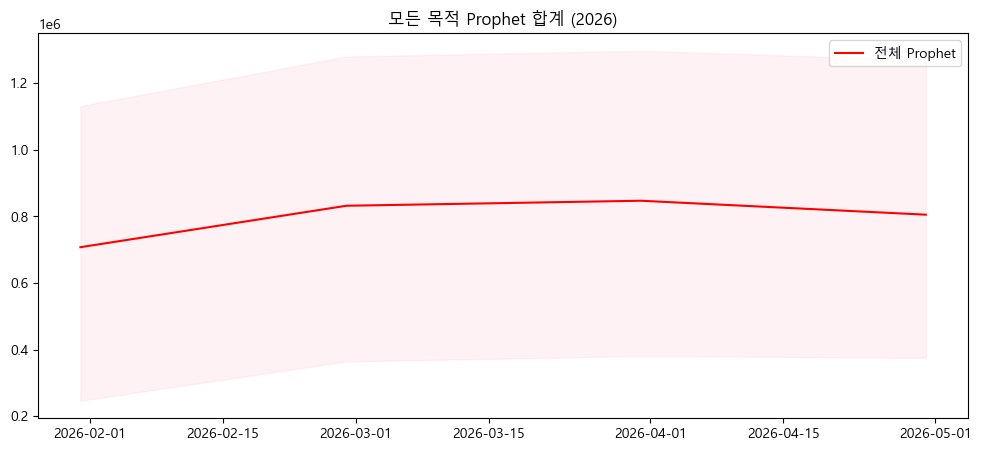

In [14]:
import pandas as pd
import numpy as np
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 데이터 로드
df = pd.read_csv('../../jin/data/processed/외국인입국자_전처리완료_딥러닝용.csv')

country = input("국적 입력 (없으면 Enter): ").strip()
purpose = input("목적 입력 (없으면 Enter): ").strip()

if country:
    df = df[df['국적'] == country]
else:
    print("🌍 국적 미선택 → 모든 나라 사용")

purpose_list = [purpose] if purpose else df['목적'].unique()

df['연월'] = df['연도'].astype(str) + '-' + df['월'].astype(str).str.zfill(2)

# 국적 미선택이면 목적별로 합산
if not country:
    grouped = df.groupby(['연월', '목적'], as_index=False)['입국자수'].sum()
else:
    grouped = df.copy()

prophet_results = {}
xgb_results = {}
actuals = {}

# ✅ 목적별 Prophet + XGB
for pur in purpose_list:
    temp = grouped[grouped['목적'] == pur].copy()
    if temp.empty:
        print(f"❌ 데이터 없음: {pur}")
        continue

    temp['ds'] = pd.to_datetime(temp['연월'])
    temp['y'] = temp['입국자수']

    # Prophet
    m = Prophet(yearly_seasonality=True)
    m.fit(temp[['ds', 'y']])
    future = m.make_future_dataframe(periods=12, freq='M')
    forecast = m.predict(future)
    prophet_results[pur] = forecast

    # XGB
    temp['연도'] = temp['ds'].dt.year
    temp['월'] = temp['ds'].dt.month
    temp['lag_1'] = temp['y'].shift(1)
    temp = temp.dropna()

    X = temp[['연도', '월', 'lag_1']]
    y = temp['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb = XGBRegressor()
    xgb.fit(X_train_scaled, y_train)
    y_pred = xgb.predict(X_test_scaled)

    xgb_df = pd.DataFrame({'ds': temp.loc[X_test.index, 'ds'].values, 'xgb_yhat': y_pred})
    xgb_results[pur] = xgb_df
    actuals[pur] = temp

    # 목적별 Prophet + XGB 그래프
    plt.figure(figsize=(12,5))
    plt.plot(temp['ds'], temp['y'], label='실제값', color='black')
    plt.plot(forecast['ds'], forecast['yhat'], label='Prophet', color='red')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                     alpha=0.2, color='pink', label='Prophet 신뢰구간')
    plt.plot(xgb_df['ds'], xgb_df['xgb_yhat'], label='XGBoost', color='blue')
    plt.title(f"[{pur}] 모든 나라 Prophet + XGBoost")
    plt.legend()
    plt.show()

# ✅ 목적 미선택이면 전체 Prophet 합계
if not purpose:
    total_prophet = pd.concat(prophet_results.values()).groupby('ds').sum().reset_index()
    total_actuals = pd.concat(actuals.values()).groupby('ds').sum().reset_index()

    plt.figure(figsize=(14,6))
    plt.plot(total_actuals['ds'], total_actuals['y'], label='실제값 합계', color='black')
    plt.plot(total_prophet['ds'], total_prophet['yhat'], label='Prophet 합계', color='red')
    plt.fill_between(total_prophet['ds'], total_prophet['yhat_lower'], total_prophet['yhat_upper'],
                     alpha=0.3, color='pink', label='Prophet 신뢰구간')
    plt.title("모든 목적 합계 Prophet")
    plt.legend()
    plt.show()

# ✅ 원하는 연월
print("\n📅 원하는 연월 선택")
now = pd.to_datetime(datetime.now()).replace(day=1)
possible = pd.date_range(now, now + pd.DateOffset(months=24), freq='MS').strftime('%Y-%m').tolist()
rows = [possible[i:i+6] for i in range(0, len(possible), 6)]
print(tabulate(rows, tablefmt="grid"))

query = input("연월 입력 (202507 또는 2025-07): ").strip().replace('-', '')
if len(query) == 6:
    query = f"{query[:4]}-{query[4:]}"
query_date = pd.to_datetime(query + "-01")
query_year = query_date.year

# ✅ 선택 목적 있으면 → 선택 목적 Prophet+XGB + 전체 Prophet 합계
if purpose:
    fc = prophet_results[purpose]
    one_year = fc[fc['ds'].dt.year == query_year]

    plt.figure(figsize=(12,5))
    plt.plot(one_year['ds'], one_year['yhat'], label='Prophet', color='red')
    plt.fill_between(one_year['ds'], one_year['yhat_lower'], one_year['yhat_upper'],
                     alpha=0.3, color='pink')
    xgb = xgb_results[purpose]
    xgb_year = xgb[xgb['ds'].dt.year == query_year]
    plt.plot(xgb_year['ds'], xgb_year['xgb_yhat'], label='XGBoost', color='blue')

    point = one_year.loc[one_year['ds'] == query_date, 'yhat']
    if not point.empty:
        plt.scatter(query_date, point.values[0], color='black', label='선택달')
        print(f"{purpose} / {query}: {int(point.values[0]):,}명")
    else:
        print(f"❗ {purpose} {query} 데이터 없음")

    plt.title(f"{purpose} Prophet+XGB ({query_year})")
    plt.legend()
    plt.show()

    total_prophet = pd.concat(prophet_results.values()).groupby('ds').sum().reset_index()
    one_year_sum = total_prophet[total_prophet['ds'].dt.year == query_year]

    plt.figure(figsize=(12,5))
    plt.plot(one_year_sum['ds'], one_year_sum['yhat'], label='전체 Prophet', color='red')
    plt.fill_between(one_year_sum['ds'], one_year_sum['yhat_lower'], one_year_sum['yhat_upper'],
                     alpha=0.2, color='pink')

    p2 = one_year_sum.loc[one_year_sum['ds'] == query_date, 'yhat']
    if not p2.empty:
        plt.scatter(query_date, p2.values[0], color='black', label='선택달')
        print(f"모든 목적 합계 / {query}: {int(p2.values[0]):,}명")
    else:
        print(f"❗ 전체 목적 {query} 데이터 없음")

    plt.title(f"모든 목적 Prophet 합계 ({query_year})")
    plt.legend()
    plt.show()

# ✅ 목적 미선택이면 → Prophet 합계만
if not purpose:
    one_year_sum = total_prophet[total_prophet['ds'].dt.year == query_year]

    plt.figure(figsize=(12,5))
    plt.plot(one_year_sum['ds'], one_year_sum['yhat'], label='전체 Prophet', color='red')
    plt.fill_between(one_year_sum['ds'], one_year_sum['yhat_lower'], one_year_sum['yhat_upper'],
                     alpha=0.2, color='pink')

    p2 = one_year_sum.loc[one_year_sum['ds'] == query_date, 'yhat']
    if not p2.empty:
        plt.scatter(query_date, p2.values[0], color='black', label='선택달')
        print(f"모든 목적 합계 / {query}: {int(p2.values[0]):,}명")
    else:
        print(f"❗ 전체 목적 {query} 데이터 없음")

    plt.title(f"모든 목적 Prophet 합계 ({query_year})")
    plt.legend()
    plt.show()


국적 입력 (없으면 Enter): 중국
목적 입력 (없으면 Enter): 


17:52:21 - cmdstanpy - INFO - Chain [1] start processing
17:52:21 - cmdstanpy - INFO - Chain [1] done processing


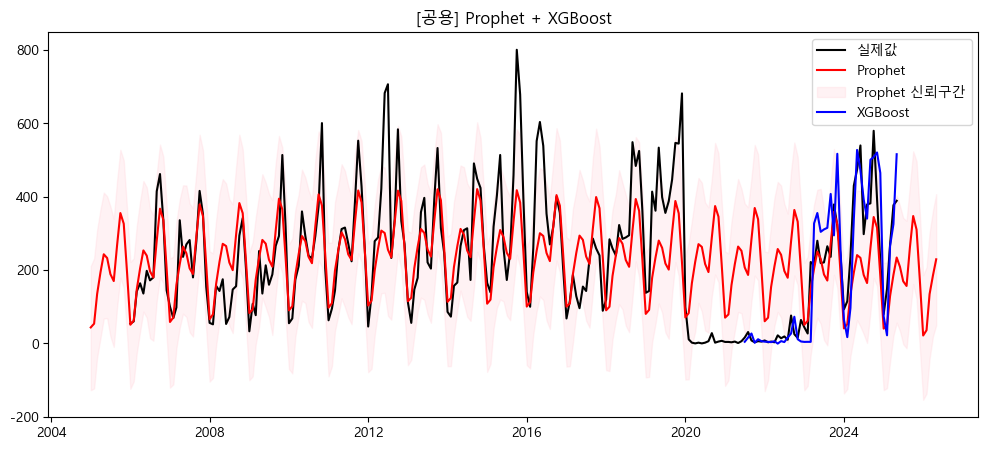

17:52:22 - cmdstanpy - INFO - Chain [1] start processing
17:52:22 - cmdstanpy - INFO - Chain [1] done processing


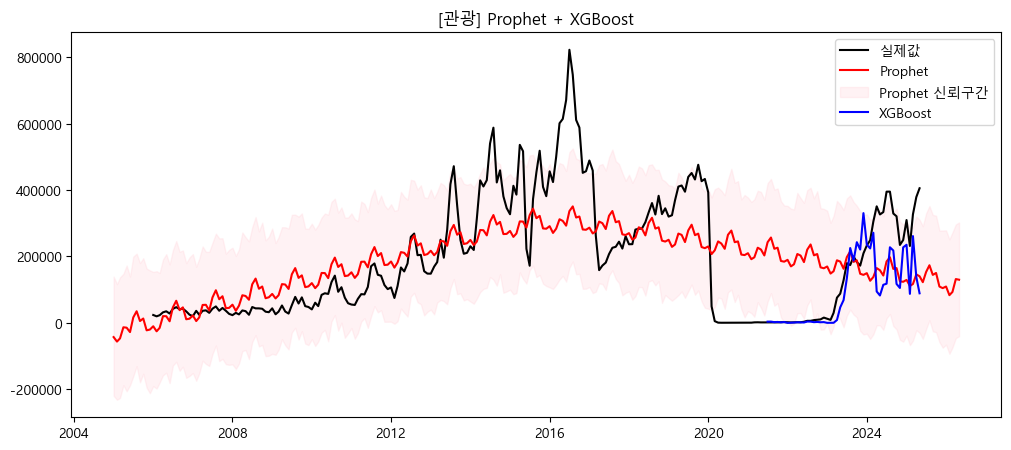

17:52:23 - cmdstanpy - INFO - Chain [1] start processing
17:52:23 - cmdstanpy - INFO - Chain [1] done processing


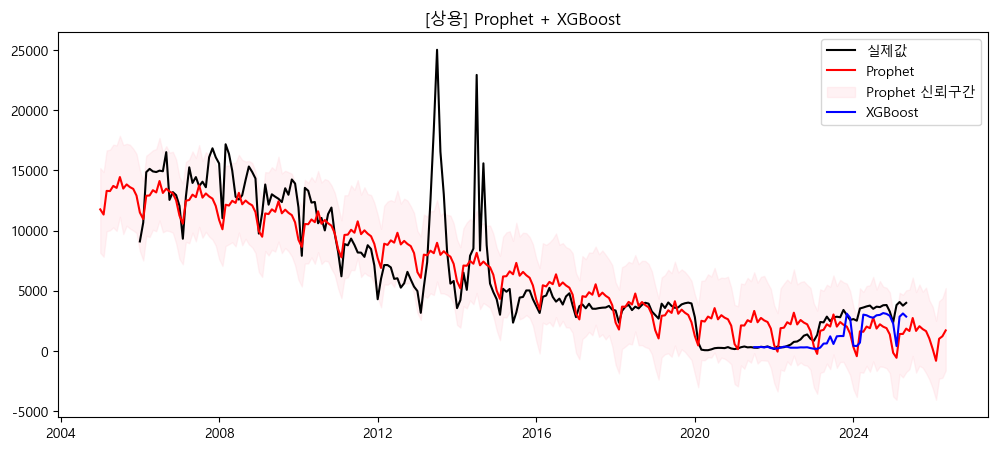

17:52:23 - cmdstanpy - INFO - Chain [1] start processing
17:52:23 - cmdstanpy - INFO - Chain [1] done processing


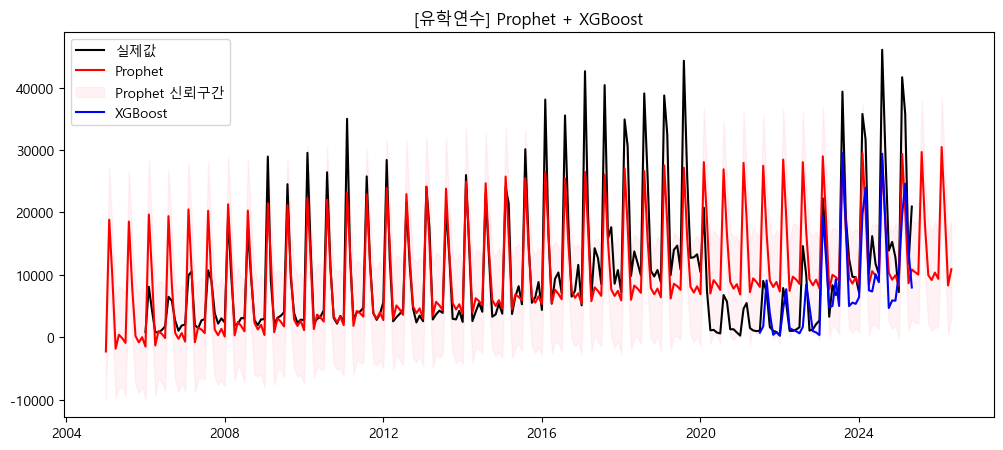

C:\Users\Admin\AppData\Local\Temp\ipykernel_9516\1247116592.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_actuals = pd.concat(actuals.values()).groupby('ds').sum().reset_index()


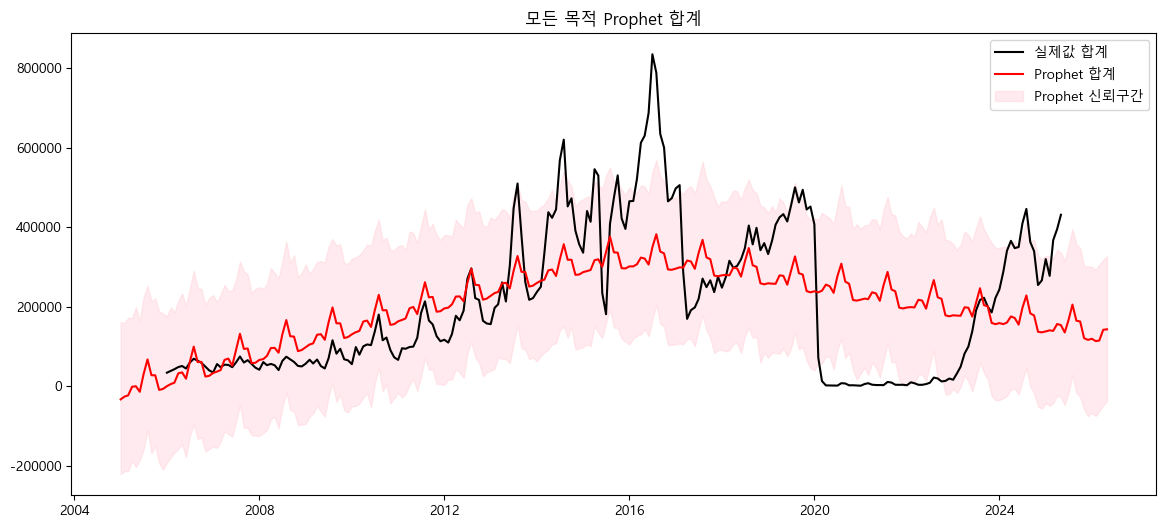


📅 원하는 연월 선택
+---------+---------+---------+---------+---------+---------+
| 2025-07 | 2025-08 | 2025-09 | 2025-10 | 2025-11 | 2025-12 |
+---------+---------+---------+---------+---------+---------+
| 2026-01 | 2026-02 | 2026-03 | 2026-04 | 2026-05 | 2026-06 |
+---------+---------+---------+---------+---------+---------+
| 2026-07 | 2026-08 | 2026-09 | 2026-10 | 2026-11 | 2026-12 |
+---------+---------+---------+---------+---------+---------+
| 2027-01 | 2027-02 | 2027-03 | 2027-04 | 2027-05 | 2027-06 |
+---------+---------+---------+---------+---------+---------+
| 2027-07 |         |         |         |         |         |
+---------+---------+---------+---------+---------+---------+
연월 입력 (202507 또는 2025-07): 202605
❗ 전체 목적 2026-05 데이터 없음


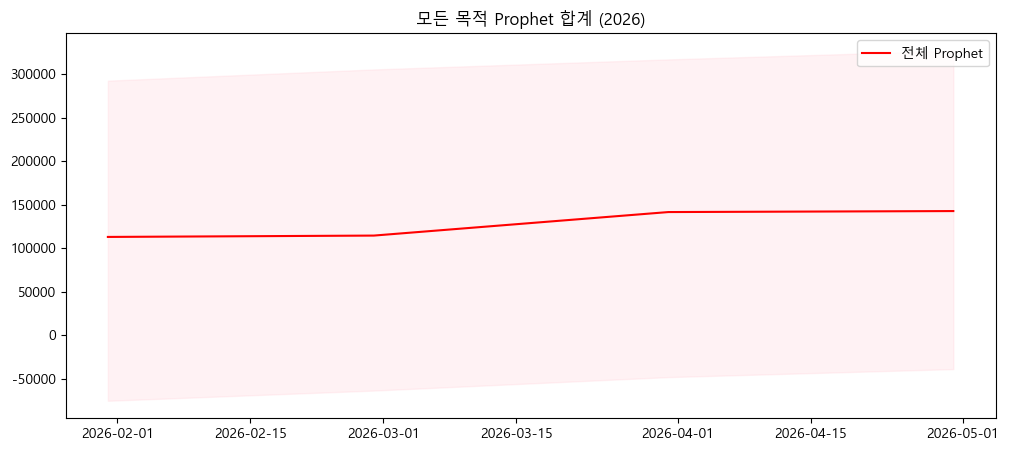

In [16]:
import pandas as pd
import numpy as np
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 데이터 로드
df = pd.read_csv('../../jin/data/processed/외국인입국자_전처리완료_딥러닝용.csv')

country = input("국적 입력 (없으면 Enter): ").strip()
purpose = input("목적 입력 (없으면 Enter): ").strip()

if country:
    df = df[df['국적'] == country]
else:
    print("🌍 국적 미선택 → 모든 나라 사용")

purpose_list = [purpose] if purpose else df['목적'].unique()

df['연월'] = df['연도'].astype(str) + '-' + df['월'].astype(str).str.zfill(2)

# 국적 미선택이면 목적별로 합산
if not country:
    grouped = df.groupby(['연월', '목적'], as_index=False)['입국자수'].sum()
else:
    grouped = df.copy()

prophet_results = {}
xgb_results = {}
actuals = {}

# ✅ Prophet + XGB 목적별 루프
for pur in purpose_list:
    temp = grouped[grouped['목적'] == pur].copy()
    if temp.empty:
        print(f"❌ 데이터 없음: {pur}")
        continue

    temp['ds'] = pd.to_datetime(temp['연월'])
    temp['y'] = temp['입국자수']

    # Prophet
    m = Prophet(yearly_seasonality=True)
    m.fit(temp[['ds', 'y']])
    future = m.make_future_dataframe(periods=12, freq='M')
    forecast = m.predict(future)
    prophet_results[pur] = forecast

    # XGB
    temp['연도'] = temp['ds'].dt.year
    temp['월'] = temp['ds'].dt.month
    temp['lag_1'] = temp['y'].shift(1)
    temp = temp.dropna()

    X = temp[['연도', '월', 'lag_1']]
    y = temp['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb = XGBRegressor()
    xgb.fit(X_train_scaled, y_train)
    y_pred = xgb.predict(X_test_scaled)

    # ✅ 안전 loc로 index 정렬
    xgb_df = pd.DataFrame({
        'ds': temp.loc[X_test.index, 'ds'].values,
        'xgb_yhat': y_pred
    })
    xgb_results[pur] = xgb_df
    actuals[pur] = temp

    # 목적별 Prophet + XGB 그래프
    plt.figure(figsize=(12,5))
    plt.plot(temp['ds'], temp['y'], label='실제값', color='black')
    plt.plot(forecast['ds'], forecast['yhat'], label='Prophet', color='red')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                     alpha=0.2, color='pink', label='Prophet 신뢰구간')
    plt.plot(xgb_df['ds'], xgb_df['xgb_yhat'], label='XGBoost', color='blue')
    plt.title(f"[{pur}] Prophet + XGBoost")
    plt.legend()
    plt.show()

# ✅ 전체 Prophet 합계 (목적 미선택 시)
if not purpose:
    total_prophet = pd.concat(prophet_results.values()).groupby('ds').sum().reset_index()
    total_actuals = pd.concat(actuals.values()).groupby('ds').sum().reset_index()

    plt.figure(figsize=(14,6))
    plt.plot(total_actuals['ds'], total_actuals['y'], label='실제값 합계', color='black')
    plt.plot(total_prophet['ds'], total_prophet['yhat'], label='Prophet 합계', color='red')
    plt.fill_between(total_prophet['ds'], total_prophet['yhat_lower'], total_prophet['yhat_upper'],
                     alpha=0.3, color='pink', label='Prophet 신뢰구간')
    plt.title("모든 목적 Prophet 합계")
    plt.legend()
    plt.show()

# ✅ 원하는 연월
print("\n📅 원하는 연월 선택")
now = pd.to_datetime(datetime.now()).replace(day=1)
possible = pd.date_range(now, now + pd.DateOffset(months=24), freq='MS').strftime('%Y-%m').tolist()
rows = [possible[i:i+6] for i in range(0, len(possible), 6)]
print(tabulate(rows, tablefmt="grid"))

query = input("연월 입력 (202507 또는 2025-07): ").strip().replace('-', '')
if len(query) == 6:
    query = f"{query[:4]}-{query[4:]}"
query_date = pd.to_datetime(query + "-01")
query_year = query_date.year

# ✅ 목적 선택시: Prophet+XGB + 전체 Prophet
if purpose:
    fc = prophet_results[purpose]
    one_year = fc[fc['ds'].dt.year == query_year]

    plt.figure(figsize=(12,5))
    plt.plot(one_year['ds'], one_year['yhat'], label='Prophet', color='red')
    plt.fill_between(one_year['ds'], one_year['yhat_lower'], one_year['yhat_upper'],
                     alpha=0.3, color='pink')

    xgb = xgb_results[purpose]
    xgb_year = xgb[xgb['ds'].dt.year == query_year]
    plt.plot(xgb_year['ds'], xgb_year['xgb_yhat'], label='XGBoost', color='blue')

    # ✅ 선택 달 비교: to_period(M)
    point = one_year[one_year['ds'].dt.to_period('M') == query_date.to_period('M')]
    if not point.empty:
        y_val = point['yhat'].values[0]
        plt.scatter(query_date, y_val, color='black', label='선택달')
        plt.annotate(f"{int(y_val):,}", xy=(query_date, y_val),
                     xytext=(0,10), textcoords='offset points',
                     ha='center', fontsize=10, color='black')
        print(f"{purpose} / {query}: {int(y_val):,}명")
    else:
        print(f"❗ {purpose} {query} 데이터 없음")

    plt.title(f"{purpose} Prophet+XGB ({query_year})")
    plt.legend()
    plt.show()

    # ✅ 전체 Prophet 합계
    total_prophet = pd.concat(prophet_results.values()).groupby('ds').sum().reset_index()
    one_year_sum = total_prophet[total_prophet['ds'].dt.year == query_year]

    plt.figure(figsize=(12,5))
    plt.plot(one_year_sum['ds'], one_year_sum['yhat'], label='전체 Prophet', color='red')
    plt.fill_between(one_year_sum['ds'], one_year_sum['yhat_lower'], one_year_sum['yhat_upper'],
                     alpha=0.2, color='pink')

    p2 = one_year_sum[one_year_sum['ds'].dt.to_period('M') == query_date.to_period('M')]
    if not p2.empty:
        y_val = p2['yhat'].values[0]
        plt.scatter(query_date, y_val, color='black', label='선택달')
        plt.annotate(f"{int(y_val):,}", xy=(query_date, y_val),
                     xytext=(0,10), textcoords='offset points',
                     ha='center', fontsize=10, color='black')
        print(f"모든 목적 합계 / {query}: {int(y_val):,}명")
    else:
        print(f"❗ 전체 목적 {query} 데이터 없음")

    plt.title(f"모든 목적 Prophet 합계 ({query_year})")
    plt.legend()
    plt.show()

# ✅ 목적 미선택이면 Prophet 합계만
if not purpose:
    one_year_sum = total_prophet[total_prophet['ds'].dt.year == query_year]

    plt.figure(figsize=(12,5))
    plt.plot(one_year_sum['ds'], one_year_sum['yhat'], label='전체 Prophet', color='red')
    plt.fill_between(one_year_sum['ds'], one_year_sum['yhat_lower'], one_year_sum['yhat_upper'],
                     alpha=0.2, color='pink')

    p2 = one_year_sum[one_year_sum['ds'].dt.to_period('M') == query_date.to_period('M')]
    if not p2.empty:
        y_val = p2['yhat'].values[0]
        plt.scatter(query_date, y_val, color='black', label='선택달')
        plt.annotate(f"{int(y_val):,}", xy=(query_date, y_val),
                     xytext=(0,10), textcoords='offset points',
                     ha='center', fontsize=10, color='black')
        print(f"모든 목적 합계 / {query}: {int(y_val):,}명")
    else:
        print(f"❗ 전체 목적 {query} 데이터 없음")

    plt.title(f"모든 목적 Prophet 합계 ({query_year})")
    plt.legend()
    plt.show()

